In [ ]:
# =============================================================================
# Script for spectral paramaterization and test-retest analysis of data from
# Wang, Y., Duan, W., Dong, D., Ding, L., & Lei, X. (2022). A test-retest resting, and cognitive state EEG dataset during multiple subject-driven states.
# Scientific Data, 9(1), Article 1. https://doi.org/10.1038/s41597-022-01607-9
#
# Created by Douglas Angus, Bond University, 2023.
# =============================================================================

In [1]:
#Load packages, create some useful functions.
import numpy as np
import scipy.io as spio
import sys
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
import fooof
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
import pingouin as pg
import pandas as pd
import os
import seaborn as sns


def printProgressBar(i, max, postText):
    n_bar = 10  # size of progress bar
    j = i/max
    sys.stdout.write('\r')
    sys.stdout.write(
        f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()


def check_nans_sample(data, nan_policy='mean'):
    """Check an array for nan values, and replace, based on policy."""

    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))

    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError('Nan policy not understood.')

    return data


def check_nans_old(data, nan_policy='mean'):
    """Check an array for nan values, and replace, based on policy."""
    outdat = []

    # Get number of rows in first dim
    for ndim in data:
        datasub = ndim

        # Find where there are nan values in the data
        nan_inds = np.where(np.isnan(datasub))

        # Apply desired nan policy to data
        if nan_policy == 'zero':
            datasub[nan_inds] = 0
        elif nan_policy == 'mean':
            datasub[nan_inds] = np.nanmean(datasub)
        else:
            raise ValueError('Nan policy not understood.')

        outdat.append(datasub)

    data = np.array(outdat)
    return data

def check_nans(data, nan_policy='mean'):
    """Check an array for nan values, and replace, based on policy."""
    outdat = []

    # Get number of rows in first dim
    for i in range(data.shape[0]):
        datasub = data[i]

        # Find where there are nan values in the data
        nan_inds = np.where(np.isnan(datasub))

        # Apply desired nan policy to data
        if nan_policy == 'zero':
            datasub[nan_inds] = 0
        elif nan_policy == 'mean':
            datasub[nan_inds] = np.nanmean(datasub)
        else:
            raise ValueError('Nan policy not understood.')

        outdat.append(datasub)

    data = np.array(outdat)
    return data


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def fooof_de_loop(subjects, condition, home_dir, file_prefix):
    # Establish dictionary
    results = {}
    results['ID'] = []
    results['exponent'] = []
    results['offset'] = []
    results['peaks'] = []
    results['r2'] = []
    results['fg'] = []
    results['theta_mean'] = []
    results['alpha_mean'] = []
    results['beta_mean'] = []
    results['theta_fooof'] = []
    results['alpha_fooof'] = []
    results['beta_fooof'] = []

    for s in range(0, np.size(subjects)):
        sub = subjects[s]

        fname = home_dir + file_prefix + str(sub) + '.mat'
        dat = spio.loadmat(fname, mdict=None, mat_dtype=True,
                           struct_as_record=False)

        ps = dat['SpectraSheetSubject']
        ps = 10**(ps/10)

        # first initialize fooof group object
        fg = FOOOFGroup(peak_width_limits=[
                        1, 8], min_peak_height=0.1, max_n_peaks=8, aperiodic_mode='fixed')
        freq_range = [2, 40]

        freqs = np.linspace(1, 100, num=np.size(ps, 1))

        # fg.fit(freqs, ps, freq_range, n_jobs=-1) #Seems to behave weird when multicore is used in a loop?
        fg.fit(freqs, ps, freq_range)
        exps_temp = fg.get_params('aperiodic_params', 'exponent')
        offset_temp = fg.get_params('aperiodic_params', 'offset')
        peaks_temp = list(fg.get_params('peak_params'))
        osc_peaks = peaks_temp
        r_squ_temp = fg.get_params('r_squared')

        #fg.save(r'\{}_FOOOF_{}'.format(str(sub),str(condition)), save_results=True, save_settings=True, save_data=True)

        theta_mean = np.mean(ps[:, np.where(freqs == find_nearest(freqs, bands.theta[0]))[
                             0][0]:np.where(freqs == find_nearest(freqs, bands.theta[1]))[0][0]], 1)
        alpha_mean = np.mean(ps[:, np.where(freqs == find_nearest(freqs, bands.alpha[0]))[
                             0][0]:np.where(freqs == find_nearest(freqs, bands.alpha[1]))[0][0]], 1)
        beta_mean = np.mean(ps[:, np.where(freqs == find_nearest(freqs, bands.beta[0]))[
                            0][0]:np.where(freqs == find_nearest(freqs, bands.beta[1]))[0][0]], 1)

        # Get peak values for each frequency band via FOOOF
        theta_fooof = get_band_peak_fg(fg, bands.theta)
        alpha_fooof = get_band_peak_fg(fg, bands.alpha)
        beta_fooof = get_band_peak_fg(fg, bands.beta)

        # Store results in dictionary
        results['ID'].append(sub)
        results['exponent'].append(exps_temp[np.newaxis])
        results['offset'].append(offset_temp[np.newaxis])
        results['peaks'].append(osc_peaks)
        results['r2'].append(r_squ_temp[np.newaxis])
        results['fg'].append(fg)
        results['theta_mean'].append(theta_mean[np.newaxis])
        results['alpha_mean'].append(alpha_mean[np.newaxis])
        results['beta_mean'].append(beta_mean[np.newaxis])
        results['theta_fooof'].append(theta_fooof[np.newaxis])
        results['alpha_fooof'].append(alpha_fooof[np.newaxis])
        results['beta_fooof'].append(beta_fooof[np.newaxis])

    return results


In [2]:
# Specify subjects to be proccessed here, bands to be analysed, and home directory
good_subs = np.array(['01','02','03','04','05','06','07','08','09','10','11','12','14','15','16','18','19','20','21','22','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','59','60'])

# Define bands for passing to get_band_peak_fg
bands = Bands({'theta': [4, 7],
               'alpha': [8, 13],
               'beta': [14, 30]})


home_dir = os.path.realpath(os.path.join(os.path.abspath(''), '..', 'Data'))


In [ ]:
#Run FOOOF over all sessions
import warnings

warnings.filterwarnings('ignore')

# Run FOOOF over session 1 data
file_prefix = '/EyesClosed_S1_'
EC_s1_results = fooof_de_loop(
    good_subs, "eyes_closed_s1", home_dir, file_prefix)

file_prefix = '/EyesOpen_S1_'
EO_s1_results = fooof_de_loop(good_subs, "eyes_open_s1", home_dir, file_prefix)

file_prefix = '/Math_S1_'
Math_s1_results = fooof_de_loop(good_subs, "math_s1", home_dir, file_prefix)

file_prefix = '/Memory_S1_'
Mem_s1_results = fooof_de_loop(good_subs, "memory_s1", home_dir, file_prefix)

file_prefix = '/Music_S1_'
music_s1_results = fooof_de_loop(good_subs, "music_s1", home_dir, file_prefix)

# Run FOOOF over session 2 data
file_prefix = '/EyesClosed_S2_'
EC_s2_results = fooof_de_loop(good_subs, "eyes_closed", home_dir, file_prefix)

file_prefix = '/EyesOpen_S2_'
EO_s2_results = fooof_de_loop(good_subs, "eyes_open_s2", home_dir, file_prefix)

file_prefix = '/Math_S2_'
Math_s2_results = fooof_de_loop(good_subs, "math_s2", home_dir, file_prefix)

file_prefix = '/Memory_S2_'
Mem_s2_results = fooof_de_loop(good_subs, "memory_s2", home_dir, file_prefix)

file_prefix = '/Music_S2_'
music_s2_results = fooof_de_loop(good_subs, "music_s2", home_dir, file_prefix)

# Run FOOOF over session 3 data
file_prefix = '/EyesClosed_S3_'
EC_s3_results = fooof_de_loop(good_subs, "eyes_closed", home_dir, file_prefix)

file_prefix = '/EyesOpen_S3_'
EO_s3_results = fooof_de_loop(good_subs, "eyes_open_s3", home_dir, file_prefix)

file_prefix = '/Math_S3_'
Math_s3_results = fooof_de_loop(good_subs, "math_s3", home_dir, file_prefix)

file_prefix = '/Memory_S3_'
Mem_s3_results = fooof_de_loop(good_subs, "memory_s3", home_dir, file_prefix)

file_prefix = '/Music_S3_'
music_s3_results = fooof_de_loop(good_subs, "music_s3", home_dir, file_prefix)


In [ ]:
#Save FOOOF results
# For saving and loading dicts, use np.save and np.load - pickle must be true. THen use [()] to get at the actual dict.
np.save(os.path.realpath(os.path.join(
    home_dir, "EC_s1_results.npy")), EC_s1_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "EO_s1_results.npy")), EO_s1_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "Math_s1_results.npy")), Math_s1_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "Mem_s1_results.npy")), Mem_s1_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "music_s1_results.npy")), music_s1_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "EC_s2_results.npy")), EC_s2_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "EO_s2_results.npy")), EO_s2_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "Math_s2_results.npy")), Math_s2_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "Mem_s2_results.npy")), Mem_s2_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "music_s2_results.npy")), music_s2_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "EC_s3_results.npy")), EC_s3_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "EO_s3_results.npy")), EO_s3_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "Math_s3_results.npy")), Math_s3_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "Mem_s3_results.npy")), Mem_s3_results)
np.save(os.path.realpath(os.path.join(
    home_dir, "music_s3_results.npy")), music_s3_results)


In [ ]:
# For getting at each individual measure, its some straight forward wrangling
# np.array(EC_s1_results['exponent']).squeeze(axis=1) #Replace the varialbe name and key name and you'll get out that data as participants X electrode.

# np.array(EC_s1_results['exponent']).squeeze(axis=1)[:,1] #For example, this returns the exponent in the EC session 1, and then extracts the first channel for each participant.

# For arrays/mesaures with multiple features eg power, bandwidth, freq, you need to pull the specific axis from the array - in this, its the last dim.
# np.array(EC_s1_results['alpha_fooof'])[:,:,:,0].squeeze()


In [3]:
# Load the data from the saved .npy files
EC_s1_results = np.load(home_dir+"/EC_s1_results.npy",
                        allow_pickle=True).tolist()
EO_s1_results = np.load(home_dir+"/EO_s1_results.npy",
                        allow_pickle=True).tolist()
Math_s1_results = np.load(
    home_dir+"/Math_s1_results.npy", allow_pickle=True).tolist()
Mem_s1_results = np.load(home_dir+"/Mem_s1_results.npy",
                         allow_pickle=True).tolist()
music_s1_results = np.load(
    home_dir+"/music_s1_results.npy", allow_pickle=True).tolist()
EC_s2_results = np.load(home_dir+"/EC_s2_results.npy",
                        allow_pickle=True).tolist()
EO_s2_results = np.load(home_dir+"/EO_s2_results.npy",
                        allow_pickle=True).tolist()
Math_s2_results = np.load(
    home_dir+"/Math_s2_results.npy", allow_pickle=True).tolist()
Mem_s2_results = np.load(home_dir+"/Mem_s2_results.npy",
                         allow_pickle=True).tolist()
music_s2_results = np.load(
    home_dir+"/music_s2_results.npy", allow_pickle=True).tolist()
EC_s3_results = np.load(home_dir+"/EC_s3_results.npy",
                        allow_pickle=True).tolist()
EO_s3_results = np.load(home_dir+"/EO_s3_results.npy",
                        allow_pickle=True).tolist()
Math_s3_results = np.load(
    home_dir+"/Math_s3_results.npy", allow_pickle=True).tolist()
Mem_s3_results = np.load(home_dir+"/Mem_s3_results.npy",
                         allow_pickle=True).tolist()
music_s3_results = np.load(
    home_dir+"/music_s3_results.npy", allow_pickle=True).tolist()


In [4]:
#Functions for calculating the ICC. 
#Multiple versions and methods have been included to make sure that the results are consistent across methods.

from numpy.linalg import pinv
from numpy import ones, kron, mean, eye, hstack, dot, tile
import numpy as np
import os
from pyirr import read_data, intraclass_correlation

# Function for adding subject IDs and session IDs to the var, and combinating the three sessions into a single array.
def combine_sessions(session1, session2, session3):

    # Add a new column to each array that indicates the subID and source
    array1 = np.stack((subID, session1, np.ones(
        (session1.shape[0], 1)).squeeze()))
    array2 = np.stack(
        (subID, session2, 2 * np.ones((session2.shape[0], 1)).squeeze()))
    array3 = np.stack(
        (subID, session3, 3 * np.ones((session3.shape[0], 1)).squeeze()))

    # Concatenate the arrays vertically
    #combined_array = np.vstack((array1, array2, array3))
    combined_array = pd.DataFrame(np.concatenate(
        (array1, array2, array3), axis=1).T, columns=['subID', 'measure', 'session'])

    # return the combined array
    return(combined_array)

# Function for adding subject IDs and session IDs to the var, and combinating the three sessions into a single array.
def combine_sessions_w(session1, session2, session3):

    # Add a new column to each array that indicates the subID and source
    array1 = np.stack((session1, session2, session3))

    # Concatenate the arrays vertically
    #combined_array = np.vstack((array1, array2, array3))
    combined_array = pd.DataFrame(
        array1.T, columns=['rater1', 'rater2', 'rater3'])

    # return the combined array
    return(combined_array)

# Function for running ICC over each channel, and returning ICC, F, and p values for each channel.
def icc_chans_max(session1, session2, session3):

    icc_chans = []
    icc_f = []
    icc_p = []
    icc_var = []

    # Loop over each channel - it will break if the chans counts etc are not identical across sessions.
    for chan in range(0, np.size(np.array(session1)[0, :])):
        # First combine the session information
        array1 = session1[:, chan]
        array2 = session2[:, chan]
        array3 = session3[:, chan]
        combined = combine_sessions(subID, array1, array2, array3)

        # Run ICC over those data
        icc = pg.intraclass_corr(
            data=combined, targets='subID', raters='session', ratings='measure')

        # Then put the output into arrays for each of the metrics we care about.
        icc_chans.append(icc.get("ICC")[4])
        icc_f.append(icc.get("F")[4])
        icc_p.append(icc.get("pval")[4])

    return(icc_chans, icc_f, icc_p)


# Function for running ICC over each channel, and returning ICC, F, and p values for each channel. Uses IRR ported from R
def icc_chans_max(session1, session2, session3, icc_type):

    icc_chans = []
    icc_f = []
    icc_p = []
    icc_var = []

    # Loop over each channel - it will break if the chans counts etc are not identical across sessions.
    for chan in range(0, np.size(np.array(session1)[0, :])):
        # First combine the session information
        array1 = session1[:, chan]
        array2 = session2[:, chan]
        array3 = session3[:, chan]
        combined = combine_sessions_w(array1, array2, array3)

        # Run ICC over those data
        #icc = intraclass_correlation(combined, "twoway", "agreement")
        icc = intraclass_correlation(
            combined, icc_type[0], icc_type[1], icc_type[2])

        # Then put the output into arrays for each of the metrics we care about.
        icc_chans.append(icc.value)
        icc_f.append(icc.Fvalue)
        icc_p.append(icc.pvalue)

    return(icc_chans, icc_f, icc_p)


# Another approach to doing the ICC, this from a stackexchange post that allows for extracting MSE etc.
def icc_stack(Y, icc_type='ICC(2,1)'):
    ''' Calculate intraclass correlation coefficient

    ICC Formulas are based on:
    Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
    assessing rater reliability. Psychological bulletin, 86(2), 420.
    icc1:  x_ij = mu + beta_j + w_ij
    icc2/3:  x_ij = mu + alpha_i + beta_j + (ab)_ij + epsilon_ij
    Code modifed from nipype algorithms.icc
    https://github.com/nipy/nipype/blob/master/nipype/algorithms/icc.py

    Args:
        Y: The data Y are entered as a 'table' ie. subjects are in rows and repeated
            measures in columns
        icc_type: type of ICC to calculate. (ICC(2,1), ICC(2,k), ICC(3,1), ICC(3,k)) 
    Returns:
        ICC: (np.array) intraclass correlation coefficient
    '''

    [n, k] = Y.shape

    # Degrees of Freedom
    dfc = k - 1
    dfe = (n - 1) * (k-1)
    dfr = n - 1

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y) ** 2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(k), np.ones((n, 1)))  # sessions
    x0 = np.tile(np.eye(n), (k, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))),
                                X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals ** 2).sum()

    MSE = SSE / dfe

    # Sum square column effect - between colums
    SSC = ((np.mean(Y, 0) - mean_Y) ** 2).sum() * n
    MSC = SSC / dfc  # / n (without n in SPSS results)

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    if icc_type == 'icc1':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        # ICC = (MSR - MSRW) / (MSR + (k-1) * MSRW)
        NotImplementedError("This method isn't implemented yet.")

    elif icc_type == 'ICC(2,1)' or icc_type == 'ICC(2,k)':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        if icc_type == 'ICC(2,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE + k * (MSC - MSE) / n)
        ICC_varbetween = (MSR - MSE)
        ICC_measurementerror = MSE + k

    elif icc_type == 'ICC(3,1)' or icc_type == 'ICC(3,k)':
        # ICC(3,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error)
        if icc_type == 'ICC(3,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE)
        ICC_varbetween = (MSR - MSE)
        ICC_measurementerror = MSE + k

    return (ICC, ICC_varbetween, ICC_measurementerror)


def icc_chans_max_2(session1, session2, session3, type):

    icc_chans = []
    icc_varout = []
    icc_measureout = []

    # Loop over each channel - it will break if the chans counts etc are not identical across sessions.
    for chan in range(0, np.size(np.array(session1)[0, :])):
        # First combine the session information
        array1 = session1[:, chan]
        array2 = session2[:, chan]
        array3 = session3[:, chan]
        combined = combine_sessions_w(array1, array2, array3)

        # Run ICC over those data
        icc, icc_var, icc_measure = icc_stack(combined.to_numpy(), type)

        # Then put the output into arrays for each of the metrics we care about.
        icc_chans.append(icc)
        icc_varout.append(icc_var)
        icc_measureout.append(icc_measure)

    return(icc_chans, icc_varout, icc_measureout)

# Now, icc functions for 2 sessions
# Function for adding subject IDs and session IDs to the var, and combinating the three sessions into a single array.
def combine_sessions_2(session1, session2):

    # Add a new column to each array that indicates the subID and source
    array1 = np.stack((session1, session2))

    # Concatenate the arrays vertically

    combined_array = pd.DataFrame(array1.T, columns=['rater1', 'rater2'])

    # return the combined array
    return(combined_array)


def icc_chans_max_2(session1, session2, type):

    icc_chans = []
    icc_varout = []
    icc_measureout = []

    # Loop over each channel - it will break if the chans counts etc are not identical across sessions.
    for chan in range(0, np.size(np.array(session1)[0, :])):
        # First combine the session information
        array1 = session1[:, chan]
        array2 = session2[:, chan]
        combined = combine_sessions_2(array1, array2)

        # Run ICC over those data
        icc, icc_var, icc_measure = icc_stack(combined.to_numpy(), type)

        # Then put the output into arrays for each of the metrics we care about.
        icc_chans.append(icc)
        icc_varout.append(icc_var)
        icc_measureout.append(icc_measure)

    return(icc_chans, icc_varout, icc_measureout)


In [5]:
#Set matplot lib and seaborn settings to look nice, white backgrounds etc.
sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_palette("colorblind")

In [6]:
# Load plotting functions and channel locations
import mne
import numpy as np
from scipy import stats as stats
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar

# We're just using this file to get sensor location information.
chan_info = mne.io.read_raw_eeglab('info_set.set', preload=True)


Reading /Users/douglasangus/Library/CloudStorage/OneDrive-BondUniversity/Aperiodic Signals and Disorders/Test Retest/Scripts/info_set.fdt
Reading 0 ... 374999  =      0.000 ...  1499.996 secs...


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_33124/4102605907.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  chan_info = mne.io.read_raw_eeglab('info_set.set', preload=True)


<Figure size 640x480 with 0 Axes>

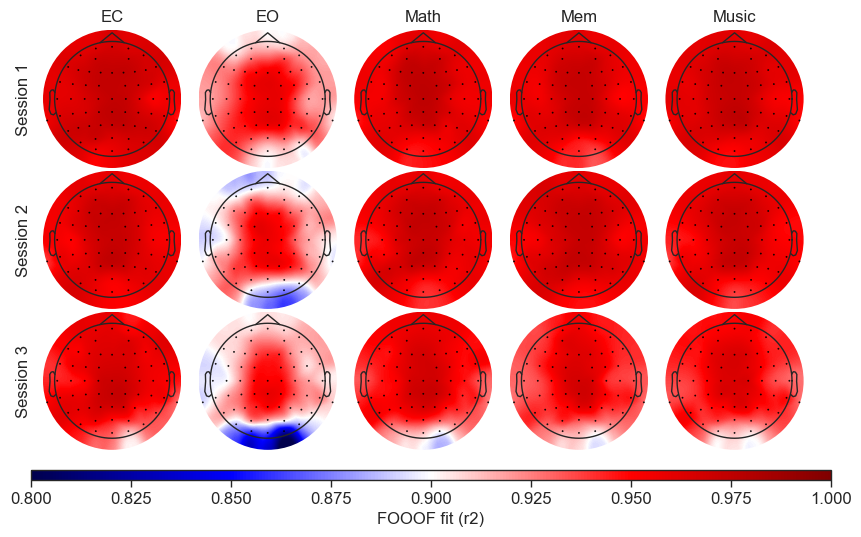

In [7]:
# Plot the r2 for each condition and session
plt.figure(3, constrained_layout=True)
fig, axs = plt.subplots(3, 5)
#fig,axs = plt.subplots(3,5,figsize=(20,10))

vlim = (.8, 1)

# Session 1
im, cm = plot_topomap(np.mean(np.array(EC_s1_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[0, 0], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(EO_s1_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[0, 1], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(Math_s1_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[0, 2], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(Mem_s1_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[0, 3], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(music_s1_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[0, 4], vlim=vlim)

# Session 2
im, cm = plot_topomap(np.mean(np.array(EC_s2_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[1, 0], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(EO_s2_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[1, 1], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(Math_s2_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[1, 2], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(Mem_s2_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[1, 3], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(music_s2_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[1, 4], vlim=vlim)

# Session 3
im, cm = plot_topomap(np.mean(np.array(EC_s3_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[2, 0], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(EO_s3_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[2, 1], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(Math_s3_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[2, 2], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(Mem_s3_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[2, 3], vlim=vlim)
im, cm = plot_topomap(np.mean(np.array(music_s3_results['r2']).squeeze(
    axis=1), axis=0), chan_info.info, size=5, cmap='jet', show=False, contours=0, image_interp='cubic', axes=axs[2, 4], vlim=vlim)


# Plot colorbar
ax_x_start = 0.12
ax_y_start = 0.05
ax_width = 0.8
ax_height = 0.02

#cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_width, ax_height])
clb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
clb.set_label('FOOOF fit (r2)', fontsize=12)
clb.ax.tick_params(labelsize=12)

# Plot titles
axs[0, 0].set_title('EC', fontsize=12)
axs[0, 1].set_title('EO', fontsize=12)
axs[0, 2].set_title('Math', fontsize=12)
axs[0, 3].set_title('Mem', fontsize=12)
axs[0, 4].set_title('Music', fontsize=12)

# Set axis labels
axs[0, 0].set_ylabel('Session 1', fontsize=12)
axs[1, 0].set_ylabel('Session 2', fontsize=12)
axs[2, 0].set_ylabel('Session 3', fontsize=12)


#Set mapping
mapping = ('seismic')

# Set cmap and colorbar to be the same for all plots (this is a bit of a hack)
for i in range(0, 5):
    axs[0, i].images[0].set_cmap(mapping)
    axs[1, i].images[0].set_cmap(mapping)
    axs[2, i].images[0].set_cmap(mapping)

    # Set plot dimensions and spacing
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.02, hspace=0.02)


<AxesSubplot: title={'center': 'Number of bad fits by condition'}>

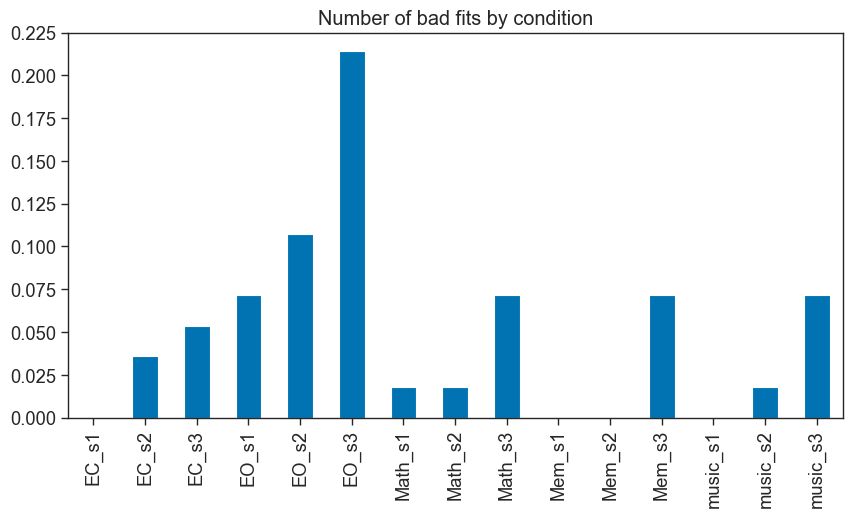

In [8]:
#Return number of channels with fits below .90
def bad_fits(fit):
    return np.sum(fit < .90)


#Create a mask for the channels that have fits below .90
def bad_fits_mask(fit):
    return np.array(fit) < .90


#Replace bad fits in each dictionary entry with NaNs using the mask function
def replace_bad_fits(fit, mask):
    return np.where(mask, np.nan, fit)

#Make the above into a function
def replace_bad_fits_all(fit, mask):
    fit['exponent'] = replace_bad_fits(fit['exponent'], mask)
    fit['offset'] = replace_bad_fits(fit['offset'], mask)
    fit['r2'] = replace_bad_fits(fit['r2'], mask)

    alpha_freq = np.array(fit['alpha_fooof'])[:,:,:,0]
    alpha_amp = np.array(fit['alpha_fooof'])[:,:,:,1]
    alpha_bw = np.array(fit['alpha_fooof'])[:,:,:,2]
    beta_freq = np.array(fit['beta_fooof'])[:,:,:,0]
    beta_amp = np.array(fit['beta_fooof'])[:,:,:,1]
    beta_bw = np.array(fit['beta_fooof'])[:,:,:,2]

    alpha_freq = replace_bad_fits(alpha_freq,mask)
    alpha_amp = replace_bad_fits(alpha_amp,mask)
    alpha_bw = replace_bad_fits(alpha_bw,mask)
    beta_freq = replace_bad_fits(beta_freq,mask)
    beta_amp = replace_bad_fits(beta_amp,mask)
    beta_bw = replace_bad_fits(beta_bw,mask)

    #Put those back into a list that is the same shape as the original
    fit['alpha_fooof'] = np.stack((alpha_freq, alpha_amp, alpha_bw), axis=3)
    fit['beta_fooof'] = np.stack((beta_freq, beta_amp, beta_bw), axis=3)

    fit['theta_mean'] = replace_bad_fits(fit['theta_mean'], mask)
    fit['alpha_mean'] = replace_bad_fits(fit['alpha_mean'], mask)
    fit['beta_mean'] = replace_bad_fits(fit['beta_mean'], mask)
    return fit

#Replace bad fits in each dictionary entry with NaNs using the mask function
EC_s1_results = replace_bad_fits_all(EC_s1_results, bad_fits_mask(EC_s1_results['r2']))
EC_s2_results = replace_bad_fits_all(EC_s2_results, bad_fits_mask(EC_s2_results['r2']))
EC_s3_results = replace_bad_fits_all(EC_s3_results, bad_fits_mask(EC_s3_results['r2']))
EO_s1_results = replace_bad_fits_all(EO_s1_results, bad_fits_mask(EO_s1_results['r2']))
EO_s2_results = replace_bad_fits_all(EO_s2_results, bad_fits_mask(EO_s2_results['r2']))
EO_s3_results = replace_bad_fits_all(EO_s3_results, bad_fits_mask(EO_s3_results['r2']))
Math_s1_results = replace_bad_fits_all(Math_s1_results, bad_fits_mask(Math_s1_results['r2']))
Math_s2_results = replace_bad_fits_all(Math_s2_results, bad_fits_mask(Math_s2_results['r2']))
Math_s3_results = replace_bad_fits_all(Math_s3_results, bad_fits_mask(Math_s3_results['r2']))
Mem_s1_results = replace_bad_fits_all(Mem_s1_results, bad_fits_mask(Mem_s1_results['r2']))
Mem_s2_results = replace_bad_fits_all(Mem_s2_results, bad_fits_mask(Mem_s2_results['r2']))
Mem_s3_results = replace_bad_fits_all(Mem_s3_results, bad_fits_mask(Mem_s3_results['r2']))
music_s1_results = replace_bad_fits_all(music_s1_results, bad_fits_mask(music_s1_results['r2']))
music_s2_results = replace_bad_fits_all(music_s2_results, bad_fits_mask(music_s2_results['r2']))
music_s3_results = replace_bad_fits_all(music_s3_results, bad_fits_mask(music_s3_results['r2']))

#Use isnan to calulate the proportion of participants with >50% nans in the r2 column
EC_s1_mask = np.sum(np.isnan(EC_s1_results['r2']).squeeze(),axis=1)/61 > .5
EC_s2_mask = np.sum(np.isnan(EC_s2_results['r2']).squeeze(),axis=1)/61 > .5
EC_s3_mask = np.sum(np.isnan(EC_s3_results['r2']).squeeze(),axis=1)/61 > .5
EO_s1_mask = np.sum(np.isnan(EO_s1_results['r2']).squeeze(),axis=1)/61 > .5
EO_s2_mask = np.sum(np.isnan(EO_s2_results['r2']).squeeze(),axis=1)/61 > .5
EO_s3_mask = np.sum(np.isnan(EO_s3_results['r2']).squeeze(),axis=1)/61 > .5
Math_s1_mask = np.sum(np.isnan(Math_s1_results['r2']).squeeze(),axis=1)/61 > .5
Math_s2_mask = np.sum(np.isnan(Math_s2_results['r2']).squeeze(),axis=1)/61 > .5
Math_s3_mask = np.sum(np.isnan(Math_s3_results['r2']).squeeze(),axis=1)/61 > .5
Mem_s1_mask = np.sum(np.isnan(Mem_s1_results['r2']).squeeze(),axis=1)/61 > .5
Mem_s2_mask = np.sum(np.isnan(Mem_s2_results['r2']).squeeze(),axis=1)/61 > .5
Mem_s3_mask = np.sum(np.isnan(Mem_s3_results['r2']).squeeze(),axis=1)/61 > .5
music_s1_mask = np.sum(np.isnan(music_s1_results['r2']).squeeze(),axis=1)/61 > .5
music_s2_mask = np.sum(np.isnan(music_s2_results['r2']).squeeze(),axis=1)/61 > .5
music_s3_mask = np.sum(np.isnan(music_s3_results['r2']).squeeze(),axis=1)/61 > .5

#Combine the masks into a single mask
mask = np.vstack((EC_s1_mask, EC_s2_mask, EC_s3_mask, EO_s1_mask, EO_s2_mask, EO_s3_mask, Math_s1_mask, Math_s2_mask, Math_s3_mask, Mem_s1_mask, Mem_s2_mask, Mem_s3_mask, music_s1_mask, music_s2_mask, music_s3_mask))
#And make it a single boolean mask
mask_combined = np.any(mask, axis=0)

#Reverse the mask to get the good fits
good_fits = ~mask_combined

mask_frame = pd.DataFrame(mask)
#Put index names on the mask
mask_frame.index = ['EC_s1', 'EC_s2', 'EC_s3', 'EO_s1', 'EO_s2', 'EO_s3', 'Math_s1', 'Math_s2', 'Math_s3', 'Mem_s1', 'Mem_s2', 'Mem_s3', 'music_s1', 'music_s2', 'music_s3']

#Identify which condition has the most bad fits and save to a csv
mask_frame.sum(axis=1).sort_values(ascending=False).to_csv('bad_fits_by_condition.csv')

#Identiy which participants have the most bad fits and save to a csv
mask_frame.sum(axis=0).sort_values(ascending=False).to_csv('bad_fits_by_participant.csv')

#Match the participants with bad fits to conditions with bad fits - show how they overlap and save to a csv
mask_frame.loc[:,mask_frame.sum(axis=0) > 0].sum(axis=1).sort_values(ascending=False).to_csv('bad_fits_by_condition_and_participant_sums.csv')

#Show how many particiants have bad fits, excluding the EO_1, EO_2, and EO_3 conditions, and show how those overlap and save to a csv
mask_frame.loc[['EC_s1', 'EC_s2', 'EC_s3', 'Math_s1', 'Math_s2', 'Math_s3', 'Mem_s1', 'Mem_s2', 'Mem_s3', 'music_s1', 'music_s2', 'music_s3'],:].sum(axis=0).sort_values(ascending=False).to_csv('bad_fits_by_participant_excluding_EO.csv')

#Make a mask for the participants with bad fits in the EC, Math, Mem, and music conditions
mask_EC_Math_Mem_music = mask_frame.loc[['EC_s1', 'EC_s2', 'EC_s3', 'Math_s1', 'Math_s2', 'Math_s3', 'Mem_s1', 'Mem_s2', 'Mem_s3', 'music_s1', 'music_s2', 'music_s3'],:].sum(axis=0) > 0

mask_EC_Math_Mem_music.sum()

#Filter mask_frame by true in any condition
mask_frame.loc[:,mask_frame.sum(axis=0) > 0].to_csv('bad_fits_by_condition_and_participant.csv')

#Filter mask_frame by true in any condition, and highlight true values and save so that the shading can be seen, save as excel file
mask_frame.loc[:,mask_frame.sum(axis=0) > 0].style.applymap(lambda x: 'background-color: red' if x else '').to_excel('bad_fits_by_condition_and_participant_highlighted.xlsx')

good_fits_noEO = ~mask_EC_Math_Mem_music

#Plot the number of good fits by condition, using mask_frame.sum(axis=1), as a proportion of the total number of participants
(mask_frame.sum(axis=1)/56).plot(kind='bar', title='Number of bad fits by condition', figsize=(10,5))


In [9]:
#Calcualte effect size for anova
def anova_effect_size(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

#Using the EC_s1_results array (and similar arrays for other conditions), calculate the total number of nans in the array per participant
EC_s1_nans = np.sum(np.isnan(EC_s1_results['r2']).squeeze(),axis=1)
EC_s2_nans = np.sum(np.isnan(EC_s2_results['r2']).squeeze(),axis=1)
EC_s3_nans = np.sum(np.isnan(EC_s3_results['r2']).squeeze(),axis=1)
EO_s1_nans = np.sum(np.isnan(EO_s1_results['r2']).squeeze(),axis=1)
EO_s2_nans = np.sum(np.isnan(EO_s2_results['r2']).squeeze(),axis=1)
EO_s3_nans = np.sum(np.isnan(EO_s3_results['r2']).squeeze(),axis=1)
Math_s1_nans = np.sum(np.isnan(Math_s1_results['r2']).squeeze(),axis=1)
Math_s2_nans = np.sum(np.isnan(Math_s2_results['r2']).squeeze(),axis=1)
Math_s3_nans = np.sum(np.isnan(Math_s3_results['r2']).squeeze(),axis=1)
Mem_s1_nans = np.sum(np.isnan(Mem_s1_results['r2']).squeeze(),axis=1)
Mem_s2_nans = np.sum(np.isnan(Mem_s2_results['r2']).squeeze(),axis=1)
Mem_s3_nans = np.sum(np.isnan(Mem_s3_results['r2']).squeeze(),axis=1)
music_s1_nans = np.sum(np.isnan(music_s1_results['r2']).squeeze(),axis=1)
music_s2_nans = np.sum(np.isnan(music_s2_results['r2']).squeeze(),axis=1)
music_s3_nans = np.sum(np.isnan(music_s3_results['r2']).squeeze(),axis=1)

#Combine the nans into a single array
nans = np.vstack((EC_s1_nans, EC_s2_nans, EC_s3_nans, EO_s1_nans, EO_s2_nans, EO_s3_nans, Math_s1_nans, Math_s2_nans, Math_s3_nans, Mem_s1_nans, Mem_s2_nans, Mem_s3_nans, music_s1_nans, music_s2_nans, music_s3_nans))

#Compare the number of nans across conditions within sessions
nans_df = pd.DataFrame(nans)
nans_df.index = ['EC_s1', 'EC_s2', 'EC_s3', 'EO_s1', 'EO_s2', 'EO_s3', 'Math_s1', 'Math_s2', 'Math_s3', 'Mem_s1', 'Mem_s2', 'Mem_s3', 'music_s1', 'music_s2', 'music_s3']
#Transpose the dataframe so that the conditions are the columns
nans_df = nans_df.T


#Do an anova comparing the number of nans across conditions, modeling both condition and session.
import statsmodels.api as sm
from statsmodels.formula.api import ols
#First, session 1
nans_df_melt = pd.melt(nans_df)
nans_df_melt.columns = ['condition', 'nans']
nans_df_melt['condition'] = nans_df_melt['condition'].astype('category')
nans_df_melt['condition'] = nans_df_melt['condition'].cat.set_categories(['EC_s1', 'EO_s1', 'Math_s1', 'Mem_s1', 'music_s1'])
#Drop the nans
nans_df_melt = nans_df_melt.dropna()
nans_df_melt['nans'] = nans_df_melt['nans'].astype('float')
model = ols('nans ~ condition', data=nans_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_effect_size(anova_table))

#Do a post-hoc test to compare the conditions, using Tukey's HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(pairwise_tukeyhsd(nans_df_melt['nans'], nans_df_melt['condition']))

#Now, session 2
nans_df_melt = pd.melt(nans_df)
nans_df_melt.columns = ['condition', 'nans']
nans_df_melt['condition'] = nans_df_melt['condition'].astype('category')
nans_df_melt['condition'] = nans_df_melt['condition'].cat.set_categories(['EC_s2', 'EO_s2','Math_s2', 'Mem_s2', 'music_s2'])
nans_df_melt = nans_df_melt.dropna()
nans_df_melt['nans'] = nans_df_melt['nans'].astype('float')
model = ols('nans ~ condition', data=nans_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_effect_size(anova_table))

#Do a post-hoc test to compare the conditions, using Tukey's HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(pairwise_tukeyhsd(nans_df_melt['nans'], nans_df_melt['condition']))

#Now, session 3
nans_df_melt = pd.melt(nans_df)
nans_df_melt.columns = ['condition', 'nans']
nans_df_melt['condition'] = nans_df_melt['condition'].astype('category')
nans_df_melt['condition'] = nans_df_melt['condition'].cat.set_categories(['EC_s3', 'EO_s3','Math_s3', 'Mem_s3', 'music_s3'])
nans_df_melt = nans_df_melt.dropna()
nans_df_melt['nans'] = nans_df_melt['nans'].astype('float')
model = ols('nans ~ condition', data=nans_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_effect_size(anova_table))

#Do a post-hoc test to compare the conditions, using Tukey's HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(pairwise_tukeyhsd(nans_df_melt['nans'], nans_df_melt['condition']))


              sum_sq     df     mean_sq          F        PR(>F)    eta_sq  \
condition   2736.300    4.0  684.075000  15.114795  3.500220e-11  0.180228   
Residual   12446.125  275.0   45.258636        NaN           NaN       NaN   

           omega_sq  
condition  0.167804  
Residual        NaN  
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1  group2  meandiff p-adj   lower    upper  reject
--------------------------------------------------------
  EC_s1    EO_s1   8.4821    0.0    4.991 11.9733   True
  EC_s1  Math_s1    1.125 0.9023  -2.3661  4.6161  False
  EC_s1   Mem_s1   1.3393   0.83  -2.1518  4.8304  False
  EC_s1 music_s1   0.5536 0.9925  -2.9376  4.0447  False
  EO_s1  Math_s1  -7.3571    0.0 -10.8483  -3.866   True
  EO_s1   Mem_s1  -7.1429    0.0  -10.634 -3.6517   True
  EO_s1 music_s1  -7.9286    0.0 -11.4197 -4.4374   True
Math_s1   Mem_s1   0.2143 0.9998  -3.2768  3.7054  False
Math_s1 music_s1  -0.5714 0.9915  -4.0626  2.9197  False
 Mem_s1 music_s

/Users/douglasangus/opt/anaconda3/envs/mne/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/douglasangus/opt/anaconda3/envs/mne/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/douglasangus/opt/anaconda3/envs/mne/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


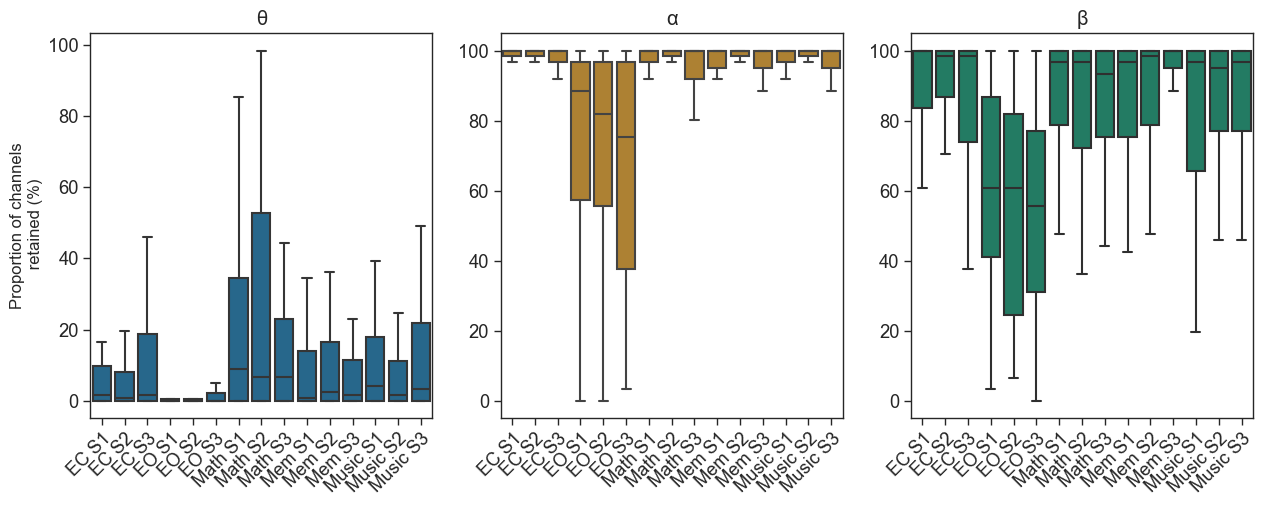

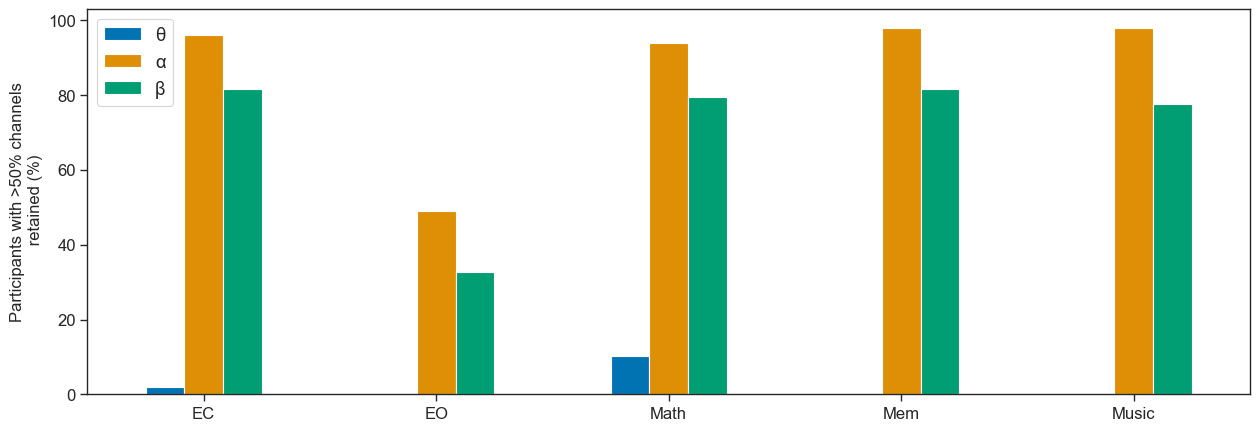

In [10]:
#Dealing with NANs
# Now, we want to get the number of NANs for each participant, for each session, for each channel, for each frequency band.

# Alpha
nan_count_alpha_ec_s1 = np.sum(
    np.isnan(np.array(EC_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_ec_s2 = np.sum(
    np.isnan(np.array(EC_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_ec_s3 = np.sum(
    np.isnan(np.array(EC_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_eo_s1 = np.sum(
    np.isnan(np.array(EO_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_eo_s2 = np.sum(
    np.isnan(np.array(EO_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_eo_s3 = np.sum(
    np.isnan(np.array(EO_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_math_s1 = np.sum(
    np.isnan(np.array(Math_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_math_s2 = np.sum(
    np.isnan(np.array(Math_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_math_s3 = np.sum(
    np.isnan(np.array(Math_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_mem_s1 = np.sum(
    np.isnan(np.array(Mem_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_mem_s2 = np.sum(
    np.isnan(np.array(Mem_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_mem_s3 = np.sum(
    np.isnan(np.array(Mem_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_music_s1 = np.sum(
    np.isnan(np.array(music_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_music_s2 = np.sum(
    np.isnan(np.array(music_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_alpha_music_s3 = np.sum(
    np.isnan(np.array(music_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)

# Beta
nan_count_beta_ec_s1 = np.sum(
    np.isnan(np.array(EC_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_ec_s2 = np.sum(
    np.isnan(np.array(EC_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_ec_s3 = np.sum(
    np.isnan(np.array(EC_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_eo_s1 = np.sum(
    np.isnan(np.array(EO_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_eo_s2 = np.sum(
    np.isnan(np.array(EO_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_eo_s3 = np.sum(
    np.isnan(np.array(EO_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_math_s1 = np.sum(
    np.isnan(np.array(Math_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_math_s2 = np.sum(
    np.isnan(np.array(Math_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_math_s3 = np.sum(
    np.isnan(np.array(Math_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_mem_s1 = np.sum(
    np.isnan(np.array(Mem_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_mem_s2 = np.sum(
    np.isnan(np.array(Mem_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_mem_s3 = np.sum(
    np.isnan(np.array(Mem_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_music_s1 = np.sum(
    np.isnan(np.array(music_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_music_s2 = np.sum(
    np.isnan(np.array(music_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)
nan_count_beta_music_s3 = np.sum(
    np.isnan(np.array(music_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze()), axis=1)


# Theta
nan_count_theta_ec_s1 = np.sum(
    np.isnan(np.array(EC_s1_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_ec_s2 = np.sum(
    np.isnan(np.array(EC_s2_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_ec_s3 = np.sum(
    np.isnan(np.array(EC_s3_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_eo_s1 = np.sum(
    np.isnan(np.array(EO_s1_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_eo_s2 = np.sum(
    np.isnan(np.array(EO_s2_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_eo_s3 = np.sum(
    np.isnan(np.array(EO_s3_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_math_s1 = np.sum(np.isnan(
    np.array(Math_s1_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_math_s2 = np.sum(np.isnan(
    np.array(Math_s2_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_math_s3 = np.sum(np.isnan(
    np.array(Math_s3_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_Mem_s1 = np.sum(np.isnan(
    np.array(Mem_s1_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_Mem_s2 = np.sum(np.isnan(
    np.array(Mem_s2_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_Mem_s3 = np.sum(np.isnan(
    np.array(Mem_s3_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_Music_s1 = np.sum(np.isnan(
    np.array(music_s1_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_Music_s2 = np.sum(np.isnan(
    np.array(music_s2_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)
nan_count_theta_Music_s3 = np.sum(np.isnan(
    np.array(music_s3_results['theta_fooof'])[:, :, :, 1].squeeze()), axis=1)

# Combines all the data so that there are 60 rows (one for each subject) and 14 columns (one for each condition), including the 3 sessions for each condition, and labels for each column
nan_count_alpha = np.vstack((nan_count_alpha_ec_s1, nan_count_alpha_ec_s2, nan_count_alpha_ec_s3, nan_count_alpha_eo_s1, nan_count_alpha_eo_s2, nan_count_alpha_eo_s3, nan_count_alpha_math_s1,
                            nan_count_alpha_math_s2, nan_count_alpha_math_s3, nan_count_alpha_mem_s1, nan_count_alpha_mem_s2,nan_count_alpha_mem_s3, nan_count_alpha_music_s1, nan_count_alpha_music_s2, nan_count_alpha_music_s3))
nan_count_beta = np.vstack((nan_count_beta_ec_s1, nan_count_beta_ec_s2, nan_count_beta_ec_s3, nan_count_beta_eo_s1, nan_count_beta_eo_s2, nan_count_beta_eo_s3, nan_count_beta_math_s1,
                           nan_count_beta_math_s2, nan_count_beta_math_s3, nan_count_beta_mem_s1, nan_count_beta_mem_s2,nan_count_alpha_mem_s3, nan_count_beta_music_s1, nan_count_beta_music_s2, nan_count_beta_music_s3))
nan_count_theta = np.vstack((nan_count_theta_ec_s1, nan_count_theta_ec_s2, nan_count_theta_ec_s3, nan_count_theta_eo_s1, nan_count_theta_eo_s2, nan_count_theta_eo_s3, nan_count_theta_math_s1,
                            nan_count_theta_math_s2, nan_count_theta_math_s3, nan_count_theta_Mem_s1, nan_count_theta_Mem_s2,nan_count_theta_Mem_s3, nan_count_theta_Music_s1, nan_count_theta_Music_s2, nan_count_theta_Music_s3))

# Create a dataframe with the data
nan_count_alpha_df = pd.DataFrame(nan_count_alpha).T
nan_count_beta_df = pd.DataFrame(nan_count_beta).T
nan_count_theta_df = pd.DataFrame(nan_count_theta).T

# Add the labels for the columns
nan_count_alpha_df.columns = ['EC S1', 'EC S2', 'EC S3', 'EO S1', 'EO S2', 'EO S3',
                              'Math S1', 'Math S2', 'Math S3', 'Mem S1', 'Mem S2',"Mem S3", 'Music S1', 'Music S2', 'Music S3']
nan_count_beta_df.columns = ['EC S1', 'EC S2', 'EC S3', 'EO S1', 'EO S2', 'EO S3',
                             'Math S1', 'Math S2', 'Math S3', 'Mem S1', 'Mem S2',"Mem S3", 'Music S1', 'Music S2', 'Music S3']
nan_count_theta_df.columns = ['EC S1', 'EC S2', 'EC S3', 'EO S1', 'EO S2', 'EO S3',
                              'Math S1', 'Math S2', 'Math S3', 'Mem S1', 'Mem S2',"Mem S3", 'Music S1', 'Music S2', 'Music S3']

# Convert the values to proportions of retained channels
nan_count_alpha_df = 100-((nan_count_alpha_df/61)*100)
nan_count_beta_df = 100-((nan_count_beta_df/61)*100)
nan_count_theta_df = 100-((nan_count_theta_df/61)*100)


# Plot the data using box plots
palette = {
    'Blue': (22, 108, 156),  
    'Orange': (194, 135, 30),
    'Green': (20, 138, 106)
}

#Divied each palette value by 255 to get the RGB values
for key, value in palette.items():
    r, g, b = value
    palette[key] = (r / 255., g / 255., b / 255.)



# Create the figure
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=nan_count_theta_df, ax=ax[0], showfliers=False,color=palette['Blue'])
sns.boxplot(data=nan_count_alpha_df, ax=ax[1], showfliers=False,color=palette['Orange'])
sns.boxplot(data=nan_count_beta_df, ax=ax[2], showfliers=False,color=palette['Green'])
ax[0].set_title('\u03B8')
ax[1].set_title('\u03B1')
ax[2].set_title('\u03B2')
ax[0].set_ylabel('Proportion of channels\n retained (%)', fontsize=12)
# Adjust the xtick labels so that they are readable and rotate them
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")


fig.set_size_inches(15, 5)
plt.show()


#Save the figure to home directory
fig.savefig('proportion_channels_retained.png', dpi=300)

# Create a mask for each condition to exclude participants who hade less than 50% of their channels retained across all 3 sessions
# First alpha
mask_ec_alpha = (nan_count_alpha_df['EC S1'] > 50) & (
    nan_count_alpha_df['EC S2'] > 50) & (nan_count_alpha_df['EC S3'] > 50)
mask_eo_alpha = (nan_count_alpha_df['EO S1'] > 50) & (
    nan_count_alpha_df['EO S2'] > 50) & (nan_count_alpha_df['EO S3'] > 50)
mask_math_alpha = (nan_count_alpha_df['Math S1'] > 50) & (
    nan_count_alpha_df['Math S2'] > 50) & (nan_count_alpha_df['Math S3'] > 50)
mask_mem_alpha = (nan_count_alpha_df['Mem S1'] > 50) & (
    nan_count_alpha_df['Mem S2'] > 50)
mask_music_alpha = (nan_count_alpha_df['Music S1'] > 50) & (
    nan_count_alpha_df['Music S2'] > 50) & (nan_count_alpha_df['Music S3'] > 50)

# Then beta
mask_ec_beta = (nan_count_beta_df['EC S1'] > 50) & (
    nan_count_beta_df['EC S2'] > 50) & (nan_count_beta_df['EC S3'] > 50)
mask_eo_beta = (nan_count_beta_df['EO S1'] > 50) & (
    nan_count_beta_df['EO S2'] > 50) & (nan_count_beta_df['EO S3'] > 50)
mask_math_beta = (nan_count_beta_df['Math S1'] > 50) & (
    nan_count_beta_df['Math S2'] > 50) & (nan_count_beta_df['Math S3'] > 50)
mask_mem_beta = (nan_count_beta_df['Mem S1'] > 50) & (
    nan_count_beta_df['Mem S2'] > 50)
mask_music_beta = (nan_count_beta_df['Music S1'] > 50) & (
    nan_count_beta_df['Music S2'] > 50) & (nan_count_beta_df['Music S3'] > 50)

# Then theta
mask_ec_theta = (nan_count_theta_df['EC S1'] > 50) & (
    nan_count_theta_df['EC S2'] > 50) & (nan_count_theta_df['EC S3'] > 50)
mask_eo_theta = (nan_count_theta_df['EO S1'] > 50) & (
    nan_count_theta_df['EO S2'] > 50) & (nan_count_theta_df['EO S3'] > 50)
mask_math_theta = (nan_count_theta_df['Math S1'] > 50) & (
    nan_count_theta_df['Math S2'] > 50) & (nan_count_theta_df['Math S3'] > 50)
mask_mem_theta = (nan_count_theta_df['Mem S1'] > 50) & (
    nan_count_theta_df['Mem S2'] > 50)
mask_music_theta = (nan_count_theta_df['Music S1'] > 50) & (
    nan_count_theta_df['Music S2'] > 50) & (nan_count_theta_df['Music S3'] > 50)

# Create a combination of all the masks for each band
mask_alpha = mask_ec_alpha  & mask_math_alpha & mask_mem_alpha & mask_music_alpha
mask_beta = mask_ec_beta  & mask_math_beta & mask_mem_beta & mask_music_beta
mask_theta = mask_ec_theta  & mask_math_theta & mask_mem_theta & mask_music_theta


# Create a dataframe that indicats the number of participants who had more than 50% of their channels retained across all 3 sessions
mask_df = pd.DataFrame()
# Theta
mask_df['\u03B8'] = [mask_ec_theta.astype(int).sum(), mask_eo_theta.astype(int).sum(), mask_math_theta.astype(
    int).sum(), mask_mem_theta.astype(int).sum(), mask_music_theta.astype(int).sum()]
#Alpha
mask_df['\u03B1'] = [mask_ec_alpha.astype(int).sum(), mask_eo_alpha.astype(int).sum(), mask_math_alpha.astype(
    int).sum(), mask_mem_alpha.astype(int).sum(), mask_music_alpha.astype(int).sum()]
# Then beta
mask_df['\u03B2'] = [mask_ec_beta.astype(int).sum(), mask_eo_beta.astype(int).sum(), mask_math_beta.astype(
    int).sum(), mask_mem_beta.astype(int).sum(), mask_music_beta.astype(int).sum()]

# And add the condition names as the index
mask_df.index = ['EC', 'EO', 'Math', 'Mem', 'Music']


percentage_mask_df = (mask_df/49)*100
percentage_mask_df.plot(kind='bar', figsize=(15, 5))
plt.ylabel('Participants with >50% channels\n retained (%)', fontsize=12)
#Make x-axis labels horizontal
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
fig.set_size_inches(5, 15)
#Save the figure to home directory
plt.savefig('mask_df.png', dpi=300)

#Combine good_fits with good_fits_alpha, only retaining those with two True values
good_fits_alpha = np.logical_and(good_fits_noEO , mask_alpha)
good_fits_beta = np.logical_and(good_fits_noEO , mask_beta)



In [11]:
#Calculate ICCs for each condition and measure - with decent filter settings
#icc_type = "ICC(2,k)"
icc_type = ["twoway", "agreement", "average"]

# First up, the exponent for each condition.

icc_chan_ec_exponent, icc_f_ec_exponent, icc_p_ec_exponent = icc_chans_max(np.array(EC_s1_results['exponent']).squeeze(
    axis=1)[good_fits_noEO], np.array(EC_s2_results['exponent']).squeeze(axis=1)[good_fits_noEO], np.array(EC_s3_results['exponent']).squeeze(axis=1)[good_fits_noEO], icc_type)
icc_chan_eo_exponent, icc_f_eo_exponent, icc_p_eo_exponent = icc_chans_max(np.array(EO_s1_results['exponent']).squeeze(
    axis=1)[good_fits_noEO], np.array(EO_s2_results['exponent']).squeeze(axis=1)[good_fits_noEO], np.array(EO_s3_results['exponent']).squeeze(axis=1)[good_fits_noEO], icc_type)
icc_chan_math_exponent, icc_f_math_exponent, icc_p_math_exponent = icc_chans_max(np.array(Math_s1_results['exponent']).squeeze(
    axis=1)[good_fits_noEO], np.array(Math_s2_results['exponent']).squeeze(axis=1)[good_fits_noEO], np.array(Math_s3_results['exponent']).squeeze(axis=1)[good_fits_noEO], icc_type)
icc_chan_mem_exponent, icc_f_mem_exponent, icc_p_mem_exponent = icc_chans_max(np.array(Mem_s1_results['exponent']).squeeze(
    axis=1)[good_fits_noEO], np.array(Mem_s2_results['exponent']).squeeze(axis=1)[good_fits_noEO], np.array(Mem_s3_results['exponent']).squeeze(axis=1)[good_fits_noEO], icc_type)
icc_chan_music_exponent, icc_f_music_exponent, icc_p_music_exponent = icc_chans_max(np.array(music_s1_results['exponent']).squeeze(
    axis=1)[good_fits_noEO], np.array(music_s2_results['exponent']).squeeze(axis=1)[good_fits_noEO], np.array(music_s3_results['exponent']).squeeze(axis=1)[good_fits_noEO], icc_type)


# Now the offset for each conditon.

icc_chan_ec_offset, icc_f_ec_offset, icc_p_ec_offset = icc_chans_max(np.array(EC_s1_results['offset']).squeeze(
    axis=1)[good_fits_noEO], np.array(EC_s2_results['offset']).squeeze(axis=1)[good_fits_noEO], np.array(EC_s3_results['offset']).squeeze(axis=1)[good_fits_noEO], icc_type)
icc_chan_eo_offset, icc_f_eo_offset, icc_p_eo_offset = icc_chans_max(np.array(EO_s1_results['offset']).squeeze(
    axis=1)[good_fits_noEO], np.array(EO_s2_results['offset']).squeeze(axis=1)[good_fits_noEO], np.array(EO_s3_results['offset']).squeeze(axis=1)[good_fits_noEO], icc_type)
icc_chan_math_offset, icc_f_math_offset, icc_p_math_offset = icc_chans_max(np.array(Math_s1_results['offset']).squeeze(
    axis=1)[good_fits_noEO], np.array(Math_s2_results['offset']).squeeze(axis=1)[good_fits_noEO], np.array(Math_s3_results['offset']).squeeze(axis=1)[good_fits_noEO], icc_type)
icc_chan_mem_offset, icc_f_mem_offset, icc_p_mem_offset = icc_chans_max(np.array(Mem_s1_results['offset']).squeeze(
    axis=1)[good_fits_noEO], np.array(Mem_s2_results['offset']).squeeze(axis=1)[good_fits_noEO], np.array(Mem_s3_results['offset']).squeeze(axis=1)[good_fits_noEO], icc_type)
icc_chan_music_offset, icc_f_music_offset, icc_p_music_offset = icc_chans_max(np.array(music_s1_results['offset']).squeeze(
    axis=1)[good_fits_noEO], np.array(music_s2_results['offset']).squeeze(axis=1)[good_fits_noEO], np.array(music_s3_results['offset']).squeeze(axis=1)[good_fits_noEO], icc_type)


# Now the alpha mean for each conditon.

icc_chan_ec_alpha_mean, icc_f_ec_alpha_mean, icc_p_ec_alpha_mean = icc_chans_max(np.array(EC_s1_results['alpha_mean']).squeeze(
    axis=1), np.array(EC_s2_results['alpha_mean']).squeeze(axis=1), np.array(EC_s3_results['alpha_mean']).squeeze(axis=1), icc_type)
icc_chan_eo_alpha_mean, icc_f_eo_alpha_mean, icc_p_eo_alpha_mean = icc_chans_max(np.array(EO_s1_results['alpha_mean']).squeeze(
    axis=1), np.array(EO_s2_results['alpha_mean']).squeeze(axis=1), np.array(EO_s3_results['alpha_mean']).squeeze(axis=1), icc_type)
icc_chan_math_alpha_mean, icc_f_math_alpha_mean, icc_p_math_alpha_mean = icc_chans_max(np.array(Math_s1_results['alpha_mean']).squeeze(
    axis=1), np.array(Math_s2_results['alpha_mean']).squeeze(axis=1), np.array(Math_s3_results['alpha_mean']).squeeze(axis=1), icc_type)
icc_chan_mem_alpha_mean, icc_f_mem_alpha_mean, icc_p_mem_alpha_mean = icc_chans_max(np.array(Mem_s1_results['alpha_mean']).squeeze(
    axis=1), np.array(Mem_s2_results['alpha_mean']).squeeze(axis=1), np.array(Mem_s3_results['alpha_mean']).squeeze(axis=1), icc_type)
icc_chan_music_alpha_mean, icc_f_music_alpha_mean, icc_p_music_alpha_mean = icc_chans_max(np.array(music_s1_results['alpha_mean']).squeeze(
    axis=1), np.array(music_s2_results['alpha_mean']).squeeze(axis=1), np.array(music_s3_results['alpha_mean']).squeeze(axis=1), icc_type)

# And the beta mean for each condition.

icc_chan_ec_beta_mean, icc_f_ec_beta_mean, icc_p_ec_beta_mean = icc_chans_max(np.array(EC_s1_results['beta_mean']).squeeze(
    axis=1), np.array(EC_s2_results['beta_mean']).squeeze(axis=1), np.array(EC_s3_results['beta_mean']).squeeze(axis=1), icc_type)
icc_chan_eo_beta_mean, icc_f_eo_beta_mean, icc_p_eo_beta_mean = icc_chans_max(np.array(EO_s1_results['beta_mean']).squeeze(
    axis=1), np.array(EO_s2_results['beta_mean']).squeeze(axis=1), np.array(EO_s3_results['beta_mean']).squeeze(axis=1), icc_type)
icc_chan_math_beta_mean, icc_f_math_beta_mean, icc_p_math_beta_mean = icc_chans_max(np.array(Math_s1_results['beta_mean']).squeeze(
    axis=1), np.array(Math_s2_results['beta_mean']).squeeze(axis=1), np.array(Math_s3_results['beta_mean']).squeeze(axis=1), icc_type)
icc_chan_mem_beta_mean, icc_f_mem_beta_mean, icc_p_mem_beta_mean = icc_chans_max(np.array(Mem_s1_results['beta_mean']).squeeze(
    axis=1), np.array(Mem_s2_results['beta_mean']).squeeze(axis=1), np.array(Mem_s3_results['beta_mean']).squeeze(axis=1), icc_type)
icc_chan_music_beta_mean, icc_f_music_beta_mean, icc_p_music_beta_mean = icc_chans_max(np.array(music_s1_results['beta_mean']).squeeze(
    axis=1), np.array(music_s2_results['beta_mean']).squeeze(axis=1), np.array(music_s3_results['beta_mean']).squeeze(axis=1), icc_type)

# And theta mean for each condition.

icc_chan_ec_theta_mean, icc_f_ec_theta_mean, icc_p_ec_theta_mean = icc_chans_max(np.array(EC_s1_results['theta_mean']).squeeze(
    axis=1), np.array(EC_s2_results['theta_mean']).squeeze(axis=1), np.array(EC_s3_results['theta_mean']).squeeze(axis=1), icc_type)
icc_chan_eo_theta_mean, icc_f_eo_theta_mean, icc_p_eo_theta_mean = icc_chans_max(np.array(EO_s1_results['theta_mean']).squeeze(
    axis=1), np.array(EO_s2_results['theta_mean']).squeeze(axis=1), np.array(EO_s3_results['theta_mean']).squeeze(axis=1), icc_type)
icc_chan_math_theta_mean, icc_f_math_theta_mean, icc_p_math_theta_mean = icc_chans_max(np.array(Math_s1_results['theta_mean']).squeeze(
    axis=1), np.array(Math_s2_results['theta_mean']).squeeze(axis=1), np.array(Math_s3_results['theta_mean']).squeeze(axis=1), icc_type)
icc_chan_mem_theta_mean, icc_f_mem_theta_mean, icc_p_mem_theta_mean = icc_chans_max(np.array(Mem_s1_results['theta_mean']).squeeze(
    axis=1), np.array(Mem_s2_results['theta_mean']).squeeze(axis=1), np.array(Mem_s3_results['theta_mean']).squeeze(axis=1), icc_type)
icc_chan_music_theta_mean, icc_f_music_theta_mean, icc_p_music_theta_mean = icc_chans_max(np.array(music_s1_results['theta_mean']).squeeze(
    axis=1), np.array(music_s2_results['theta_mean']).squeeze(axis=1), np.array(music_s3_results['theta_mean']).squeeze(axis=1), icc_type)

# Now the paramterised alpha power for each condition.
icc_chan_ec_alpha_param, icc_f_ec_alpha_param, icc_p_ec_alpha_param = icc_chans_max(check_nans(np.array(EC_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_ec_alpha], check_nans(
    np.array(EC_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_ec_alpha], check_nans(np.array(EC_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_ec_alpha], icc_type)
icc_chan_eo_alpha_param, icc_f_eo_alpha_param, icc_p_eo_alpha_param = icc_chans_max(check_nans(np.array(EO_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_eo_alpha], check_nans(
    np.array(EO_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_eo_alpha], check_nans(np.array(EO_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_eo_alpha], icc_type)
icc_chan_math_alpha_param, icc_f_math_alpha_param, icc_p_math_alpha_param = icc_chans_max(check_nans(np.array(Math_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_math_alpha], check_nans(
    np.array(Math_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_math_alpha], check_nans(np.array(Math_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_math_alpha], icc_type)
icc_chan_mem_alpha_param, icc_f_mem_alpha_param, icc_p_mem_alpha_param = icc_chans_max(check_nans(np.array(Mem_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_mem_alpha], check_nans(
    np.array(Mem_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_mem_alpha], check_nans(np.array(Mem_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_mem_alpha], icc_type)
icc_chan_music_alpha_param, icc_f_music_alpha_param, icc_p_music_alpha_param = icc_chans_max(check_nans(np.array(music_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_music_alpha], check_nans(
    np.array(music_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_music_alpha], check_nans(np.array(music_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_music_alpha], icc_type)


# And paramaterised alpha frequency for each condition.
icc_chan_ec_alpha_param_freq, icc_f_ec_alpha_param_freq, icc_p_ec_alpha_param_freq = icc_chans_max(check_nans(np.array(EC_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze(
    ))[mask_ec_alpha], check_nans(np.array(EC_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_ec_alpha], check_nans(np.array(EC_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_ec_alpha], icc_type)
icc_chan_eo_alpha_param_freq, icc_f_eo_alpha_param_freq, icc_p_eo_alpha_param_freq = icc_chans_max(check_nans(np.array(EO_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze(
    ))[mask_eo_alpha], check_nans(np.array(EO_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_eo_alpha], check_nans(np.array(EO_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_eo_alpha], icc_type)
icc_chan_math_alpha_param_freq, icc_f_math_alpha_param_freq, icc_p_math_alpha_param_freq = icc_chans_max(check_nans(np.array(Math_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze(
    ))[mask_math_alpha], check_nans(np.array(Math_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_math_alpha], check_nans(np.array(Math_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_math_alpha], icc_type)
icc_chan_mem_alpha_param_freq, icc_f_mem_alpha_param_freq, icc_p_mem_alpha_param_freq = icc_chans_max(check_nans(np.array(Mem_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze(
    ))[mask_mem_alpha], check_nans(np.array(Mem_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_mem_alpha], check_nans(np.array(Mem_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_mem_alpha], icc_type)
icc_chan_music_alpha_param_freq, icc_f_music_alpha_param_freq, icc_p_music_alpha_param_freq = icc_chans_max(check_nans(np.array(music_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze(
    ))[mask_music_alpha], check_nans(np.array(music_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_music_alpha], check_nans(np.array(music_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_music_alpha], icc_type)


# And paramaterised alpha bandwidth for each condition.
icc_chan_ec_alpha_param_bw, icc_f_ec_alpha_param_bw, icc_p_ec_alpha_param_bw = icc_chans_max(check_nans(np.array(EC_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze(
    ))[mask_ec_alpha], check_nans(np.array(EC_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_ec_alpha], check_nans(np.array(EC_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_ec_alpha], icc_type)
icc_chan_eo_alpha_param_bw, icc_f_eo_alpha_param_bw, icc_p_eo_alpha_param_bw = icc_chans_max(check_nans(np.array(EO_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze(
    ))[mask_eo_alpha], check_nans(np.array(EO_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_eo_alpha], check_nans(np.array(EO_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_eo_alpha], icc_type)
icc_chan_math_alpha_param_bw, icc_f_math_alpha_param_bw, icc_p_math_alpha_param_bw = icc_chans_max(check_nans(np.array(Math_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze(
    ))[mask_math_alpha], check_nans(np.array(Math_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_math_alpha], check_nans(np.array(Math_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_math_alpha], icc_type)
icc_chan_mem_alpha_param_bw, icc_f_mem_alpha_param_bw, icc_p_mem_alpha_param_bw = icc_chans_max(check_nans(np.array(Mem_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze(
    ))[mask_mem_alpha], check_nans(np.array(Mem_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_mem_alpha], check_nans(np.array(Mem_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_mem_alpha], icc_type)
icc_chan_music_alpha_param_bw, icc_f_music_alpha_param_bw, icc_p_music_alpha_param_bw = icc_chans_max(check_nans(np.array(music_s1_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze(
    ))[mask_music_alpha], check_nans(np.array(music_s2_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_music_alpha], check_nans(np.array(music_s3_results['alpha_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_music_alpha], icc_type)

# Now, beta power for each condition.
icc_chan_ec_beta_param, icc_f_ec_beta_param, icc_p_ec_beta_param = icc_chans_max(check_nans(np.array(EC_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_ec_beta], check_nans(
    np.array(EC_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_ec_beta], check_nans(np.array(EC_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_ec_beta], icc_type)
icc_chan_eo_beta_param, icc_f_eo_beta_param, icc_p_eo_beta_param = icc_chans_max(check_nans(np.array(EO_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_eo_beta], check_nans(
    np.array(EO_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_eo_beta], check_nans(np.array(EO_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_eo_beta], icc_type)
icc_chan_math_beta_param, icc_f_math_beta_param, icc_p_math_beta_param = icc_chans_max(check_nans(np.array(Math_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_math_beta], check_nans(
    np.array(Math_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_math_beta], check_nans(np.array(Math_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_math_beta], icc_type)
icc_chan_mem_beta_param, icc_f_mem_beta_param, icc_p_mem_beta_param = icc_chans_max(check_nans(np.array(Mem_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_mem_beta], check_nans(
    np.array(Mem_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_mem_beta], check_nans(np.array(Mem_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_mem_beta], icc_type)
icc_chan_music_beta_param, icc_f_music_beta_param, icc_p_music_beta_param = icc_chans_max(check_nans(np.array(music_s1_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_music_beta], check_nans(
    np.array(music_s2_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_music_beta], check_nans(np.array(music_s3_results['beta_fooof'])[good_fits_noEO, :, :, 1].squeeze())[mask_music_beta], icc_type)

# And beta frequency
icc_chan_ec_beta_freq, icc_f_ec_beta_freq, icc_p_ec_beta_freq = icc_chans_max(check_nans(np.array(EC_s1_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_ec_beta], check_nans(
    np.array(EC_s2_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_ec_beta], check_nans(np.array(EC_s3_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_ec_beta], icc_type)
icc_chan_eo_beta_freq, icc_f_eo_beta_freq, icc_p_eo_beta_freq = icc_chans_max(check_nans(np.array(EO_s1_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_eo_beta], check_nans(
    np.array(EO_s2_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_eo_beta], check_nans(np.array(EO_s3_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_eo_beta], icc_type)
icc_chan_math_beta_freq, icc_f_math_beta_freq, icc_p_math_beta_freq = icc_chans_max(check_nans(np.array(Math_s1_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_math_beta], check_nans(
    np.array(Math_s2_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_math_beta], check_nans(np.array(Math_s3_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_math_beta], icc_type)
icc_chan_mem_beta_freq, icc_f_mem_beta_freq, icc_p_mem_beta_freq = icc_chans_max(check_nans(np.array(Mem_s1_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_mem_beta], check_nans(
    np.array(Mem_s2_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_mem_beta], check_nans(np.array(Mem_s3_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_mem_beta], icc_type)
icc_chan_music_beta_freq, icc_f_music_beta_freq, icc_p_music_beta_freq = icc_chans_max(check_nans(np.array(music_s1_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_music_beta], check_nans(
    np.array(music_s2_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_music_beta], check_nans(np.array(music_s3_results['beta_fooof'])[good_fits_noEO, :, :, 0].squeeze())[mask_music_beta], icc_type)

# And beta bandwidth
icc_chan_ec_beta_bw, icc_f_ec_beta_bw, icc_p_ec_beta_bw = icc_chans_max(check_nans(np.array(EC_s1_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_ec_beta], check_nans(
    np.array(EC_s2_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_ec_beta], check_nans(np.array(EC_s3_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_ec_beta], icc_type)
icc_chan_eo_beta_bw, icc_f_eo_beta_bw, icc_p_eo_beta_bw = icc_chans_max(check_nans(np.array(EO_s1_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_eo_beta], check_nans(
    np.array(EO_s2_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_eo_beta], check_nans(np.array(EO_s3_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_eo_beta], icc_type)
icc_chan_math_beta_bw, icc_f_math_beta_bw, icc_p_math_beta_bw = icc_chans_max(check_nans(np.array(Math_s1_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_math_beta], check_nans(
    np.array(Math_s2_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_math_beta], check_nans(np.array(Math_s3_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_math_beta], icc_type)
icc_chan_mem_beta_bw, icc_f_mem_beta_bw, icc_p_mem_beta_bw = icc_chans_max(check_nans(np.array(Mem_s1_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_mem_beta], check_nans(
    np.array(Mem_s2_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_mem_beta], check_nans(np.array(Mem_s3_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_mem_beta], icc_type)
icc_chan_music_beta_bw, icc_f_music_beta_bw, icc_p_music_beta_bw = icc_chans_max(check_nans(np.array(music_s1_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_music_beta], check_nans(
    np.array(music_s2_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_music_beta], check_nans(np.array(music_s3_results['beta_fooof'])[good_fits_noEO, :, :, 2].squeeze())[mask_music_beta], icc_type)


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_33124/675755073.py:81: RuntimeWarning: Mean of empty slice
  datasub[nan_inds] = np.nanmean(datasub)
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_33124/675755073.py:81: RuntimeWarning: Mean of empty slice
  datasub[nan_inds] = np.nanmean(datasub)
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_33124/675755073.py:81: RuntimeWarning: Mean of empty slice
  datasub[nan_inds] = np.nanmean(datasub)
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_33124/675755073.py:81: RuntimeWarning: Mean of empty slice
  datasub[nan_inds] = np.nanmean(datasub)
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_33124/675755073.py:81: RuntimeWarning: Mean of empty slice
  datasub[nan_inds] = np.nanmean(datasub)
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_33124/675755073.py:81: RuntimeWarning: Mean of empty slice
  datasub[nan_inds] = np.nanmean(datasub)
/var/folders/n8/txtqf2715w11h2b0g0xqfc04

<Figure size 640x480 with 0 Axes>

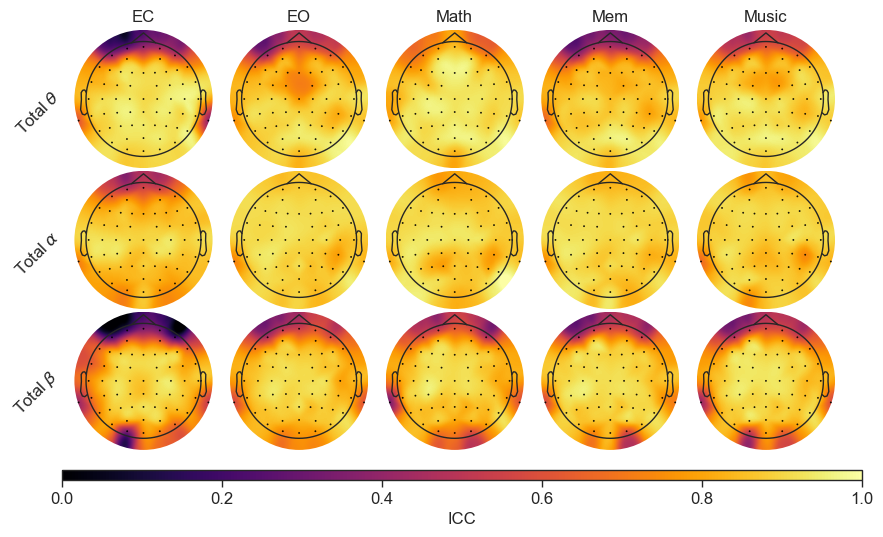

In [13]:
#Plot the ICCs for total powers
#Set mapping for most of our figures.
mapping = 'inferno'
plt.figure(1, constrained_layout=True)
fig, axs = plt.subplots(3, 5)

# theta power
im, cm = plot_topomap(icc_chan_eo_theta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 0])
im, cm = plot_topomap(icc_chan_ec_theta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 1])
im, cm = plot_topomap(icc_chan_math_theta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 2])
im, cm = plot_topomap(icc_chan_mem_theta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 3])
im, cm = plot_topomap(icc_chan_music_theta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 4])

# Now alpha power
im, cm = plot_topomap(icc_chan_eo_alpha_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 0])
im, cm = plot_topomap(icc_chan_ec_alpha_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 1])
im, cm = plot_topomap(icc_chan_math_alpha_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 2])
im, cm = plot_topomap(icc_chan_mem_alpha_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 3])
im, cm = plot_topomap(icc_chan_music_alpha_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 4])

# Now beta power
im, cm = plot_topomap(icc_chan_eo_beta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 0])
im, cm = plot_topomap(icc_chan_ec_beta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 1])
im, cm = plot_topomap(icc_chan_math_beta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 2])
im, cm = plot_topomap(icc_chan_mem_beta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 3])
im, cm = plot_topomap(icc_chan_music_beta_mean, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 4])


# Plot colorbar
ax_x_start = 0.12
ax_y_start = 0.05
ax_width = 0.8
ax_height = 0.02


cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_width, ax_height])
clb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
clb.set_label('ICC', fontsize=12)
clb.ax.tick_params(labelsize=12)

# Plot titles
axs[0, 0].set_title('EC', fontsize=12)
axs[0, 1].set_title('EO', fontsize=12)
axs[0, 2].set_title('Math', fontsize=12)
axs[0, 3].set_title('Mem', fontsize=12)
axs[0, 4].set_title('Music', fontsize=12)

# Set axis labels to use greek letters
axs[0, 0].set_ylabel(r'Total $\theta$', fontsize=12, rotation=45, ha='right')
axs[1, 0].set_ylabel(r'Total $\alpha$', fontsize=12, rotation=45, ha='right')
axs[2, 0].set_ylabel(r'Total $\beta$', fontsize=12, rotation=45, ha='right')

# Set cmap and colorbar to be the same for all plots (this is a bit of a hack)
for i in range(0, 5):
    axs[0, i].images[0].set_cmap(mapping)
    axs[1, i].images[0].set_cmap(mapping)
    axs[2, i].images[0].set_cmap(mapping)

    # Set plot dimensions and spacing
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

#Save figure to home directory
fig.savefig('ICC_total_power_topomap.png', dpi=300)


<Figure size 640x480 with 0 Axes>

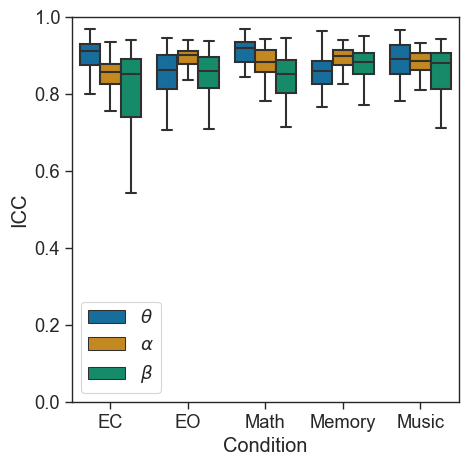

In [14]:
#Box plots for ICCs of total powers
import seaborn as sns


# Theta
ECs_theta = pd.DataFrame([np.array(icc_chan_eo_theta_mean), np.repeat(
    "EO", 61), np.repeat("Theta", 61)]).T
EOs_theta = pd.DataFrame([np.array(icc_chan_ec_theta_mean), np.repeat(
    "EC", 61), np.repeat("Theta", 61)]).T
maths_theta = pd.DataFrame([np.array(icc_chan_math_theta_mean), np.repeat(
    "Math", 61), np.repeat("Theta", 61)]).T
mems_theta = pd.DataFrame([np.array(icc_chan_mem_theta_mean), np.repeat(
    "Memory", 61), np.repeat("Theta", 61)]).T
musics_theta = pd.DataFrame([np.array(icc_chan_music_theta_mean), np.repeat(
    "Music", 61), np.repeat("Theta", 61)]).T

# Alpha
ECs_alpha_mean = pd.DataFrame([np.array(icc_chan_eo_alpha_mean), np.repeat(
    "EO", 61), np.repeat("Alpha Mean", 61)]).T
EOs_alpha_mean = pd.DataFrame([np.array(icc_chan_ec_alpha_mean), np.repeat(
    "EC", 61), np.repeat("Alpha Mean", 61)]).T
maths_alpha_mean = pd.DataFrame([np.array(icc_chan_math_alpha_mean), np.repeat(
    "Math", 61), np.repeat("Alpha Mean", 61)]).T
mems_alpha_mean = pd.DataFrame([np.array(icc_chan_mem_alpha_mean), np.repeat(
    "Memory", 61), np.repeat("Alpha Mean", 61)]).T
musics_alpha_mean = pd.DataFrame([np.array(icc_chan_music_alpha_mean), np.repeat(
    "Music", 61), np.repeat("Alpha Mean", 61)]).T

# Now beta
ECs_beta_mean = pd.DataFrame([np.array(icc_chan_eo_beta_mean), np.repeat(
    "EO", 61), np.repeat("Beta Mean", 61)]).T
EOs_beta_mean = pd.DataFrame([np.array(icc_chan_ec_beta_mean), np.repeat(
    "EC", 61), np.repeat("Beta Mean", 61)]).T
maths_beta_mean = pd.DataFrame([np.array(icc_chan_math_beta_mean), np.repeat(
    "Math", 61), np.repeat("Beta Mean", 61)]).T
mems_beta_mean = pd.DataFrame([np.array(icc_chan_mem_beta_mean), np.repeat(
    "Memory", 61), np.repeat("Beta Mean", 61)]).T
musics_beta_mean = pd.DataFrame([np.array(icc_chan_music_beta_mean), np.repeat(
    "Music", 61), np.repeat("Beta Mean", 61)]).T

# Merge the dataframes
icc_plotdat = pd.concat([ECs_theta, EOs_theta, maths_theta, mems_theta, musics_theta, ECs_alpha_mean, EOs_alpha_mean, maths_alpha_mean,
                        mems_alpha_mean, musics_alpha_mean, ECs_beta_mean, EOs_beta_mean, maths_beta_mean, mems_beta_mean, musics_beta_mean], axis=0)


icc_plotdat.columns = ['ICC', 'Condition', 'EEG Measure']
icc_plotdat = icc_plotdat.astype({'ICC': 'float64'}, copy=False)

# Plot icc_plotdata with a boxplot using seaborn
plt.figure(5, constrained_layout=True)
fig, ax = plt.subplots()

# Set size
fig.set_size_inches(5, 5)

sns.boxplot(x="Condition", y="ICC", hue="EEG Measure", data=icc_plotdat,
            palette="colorblind", dodge=True, ax=ax, showfliers=False)
ax.set_xticklabels(['EC', 'EO', 'Math', "Memory", "Music"])

# Set axis limits to be 0 - 1
ax.set_ylim(0, 1)

# Change legend labels to use lower case greek letters
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [r'$\theta$', r'$\alpha$', r'$\beta$'])

#Save figure to home directory
fig.savefig('ICC_total_power_boxplot.png', dpi=300)


<Figure size 640x480 with 0 Axes>

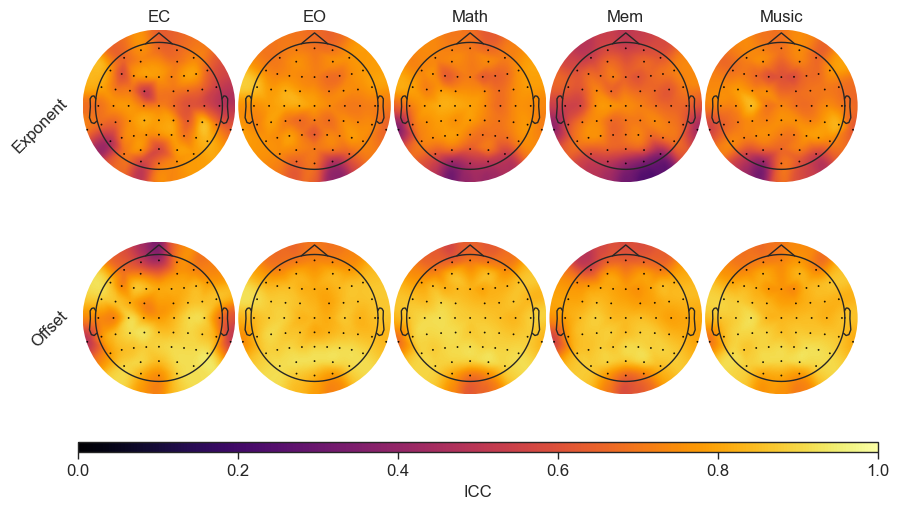

In [15]:
#Plot the ICCs for the exponent and offset
#Set mapping for most of our figures.
mapping = 'inferno'
plt.figure(1, constrained_layout=True)
fig, axs = plt.subplots(2, 5)

im, cm = plot_topomap(icc_chan_eo_exponent, chan_info.info, size=5, cmap="jet",
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 0])
im, cm = plot_topomap(icc_chan_ec_exponent, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 1])
im, cm = plot_topomap(icc_chan_math_exponent, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 2])
im, cm = plot_topomap(icc_chan_mem_exponent, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 3])
im, cm = plot_topomap(icc_chan_music_exponent, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 4])

im, cm = plot_topomap(icc_chan_eo_offset, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 0])
im, cm = plot_topomap(icc_chan_ec_offset, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 1])
im, cm = plot_topomap(icc_chan_math_offset, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 2])
im, cm = plot_topomap(icc_chan_mem_offset, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 3])
im, cm = plot_topomap(icc_chan_music_offset, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 4])

# Plot colorbar
ax_x_start = 0.12
ax_y_start = 0.05
ax_width = 0.8
ax_height = 0.02


cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_width, ax_height])
clb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
clb.set_label('ICC', fontsize=12)
clb.ax.tick_params(labelsize=12)

# Plot titles
axs[0, 0].set_title('EC', fontsize=12)
axs[0, 1].set_title('EO', fontsize=12)
axs[0, 2].set_title('Math', fontsize=12)
axs[0, 3].set_title('Mem', fontsize=12)
axs[0, 4].set_title('Music', fontsize=12)

# Set axis labels
axs[0, 0].set_ylabel('Exponent', fontsize=12, rotation=45, ha='right')
axs[1, 0].set_ylabel('Offset', fontsize=12, rotation=45, ha='right')


# Set cmap and colorbar to be the same for all plots (this is a bit of a hack)
for i in range(0, 5):
    axs[0, i].images[0].set_cmap(mapping)
    axs[1, i].images[0].set_cmap(mapping)

# Set plot dimensions and spacing
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

#Save figure to home directory
fig.savefig('ICC_aperiodic_power_topomap.png', dpi=300)


<Figure size 640x480 with 0 Axes>

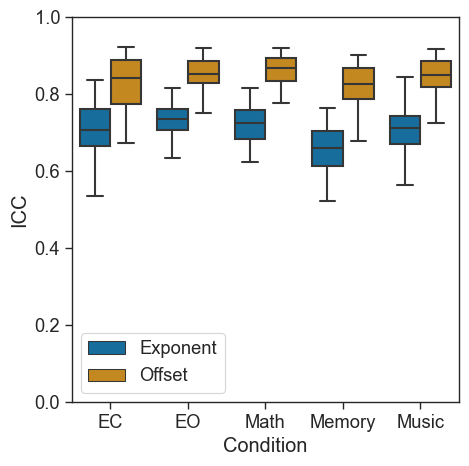

In [16]:
#Box plots for aperiodic ICCs
import seaborn as sns


ECs_exponent = pd.DataFrame([np.array(icc_chan_eo_exponent), np.repeat(
    "EO", 61), np.repeat("Exponent", 61)]).T
EOs_exponent = pd.DataFrame([np.array(icc_chan_ec_exponent), np.repeat(
    "EC", 61), np.repeat("Exponent", 61)]).T
maths_exponent = pd.DataFrame([np.array(icc_chan_math_exponent), np.repeat(
    "Math", 61), np.repeat("Exponent", 61)]).T
mems_exponent = pd.DataFrame([np.array(icc_chan_mem_exponent), np.repeat(
    "Memory", 61), np.repeat("Exponent", 61)]).T
musics_exponent = pd.DataFrame([np.array(icc_chan_music_exponent), np.repeat(
    "Music", 61), np.repeat("Exponent", 61)]).T

ECs_offset = pd.DataFrame(
    [np.array(icc_chan_eo_offset), np.repeat("EO", 61), np.repeat("Offset", 61)]).T
EOs_offset = pd.DataFrame(
    [np.array(icc_chan_ec_offset), np.repeat("EC", 61), np.repeat("Offset", 61)]).T
maths_offset = pd.DataFrame([np.array(icc_chan_math_offset), np.repeat(
    "Math", 61), np.repeat("Offset", 61)]).T
mems_offset = pd.DataFrame([np.array(icc_chan_mem_offset), np.repeat(
    "Memory", 61), np.repeat("Offset", 61)]).T
musics_offset = pd.DataFrame([np.array(icc_chan_music_offset), np.repeat(
    "Music", 61), np.repeat("Offset", 61)]).T


# Merge the dataframes
icc_plotdat = pd.concat([ECs_exponent, EOs_exponent, maths_exponent, mems_exponent,
                        musics_exponent, ECs_offset, EOs_offset, maths_offset, mems_offset, musics_offset], axis=0)

icc_plotdat.columns = ['ICC', 'Condition', 'EEG Measure']
icc_plotdat = icc_plotdat.astype({'ICC': 'float64'}, copy=False)


# Plot icc_plotdata with a boxplot using seaborn
plt.figure(5, constrained_layout=True)
fig, ax = plt.subplots()

# Set size
fig.set_size_inches(5, 5)

sns.boxplot(x="Condition", y="ICC", hue="EEG Measure", data=icc_plotdat,
            palette="colorblind", dodge=True, ax=ax, showfliers=False)
ax.set_xticklabels(['EC', 'EO', 'Math', "Memory", "Music"])

ax.get_legend().set_title(None)

# Set axis limits to be 0 - 1
ax.set_ylim(0, 1)

#save figure to home directory
fig.savefig('ICC_aperiodic_boxplot.png', dpi=300)

<Figure size 640x480 with 0 Axes>

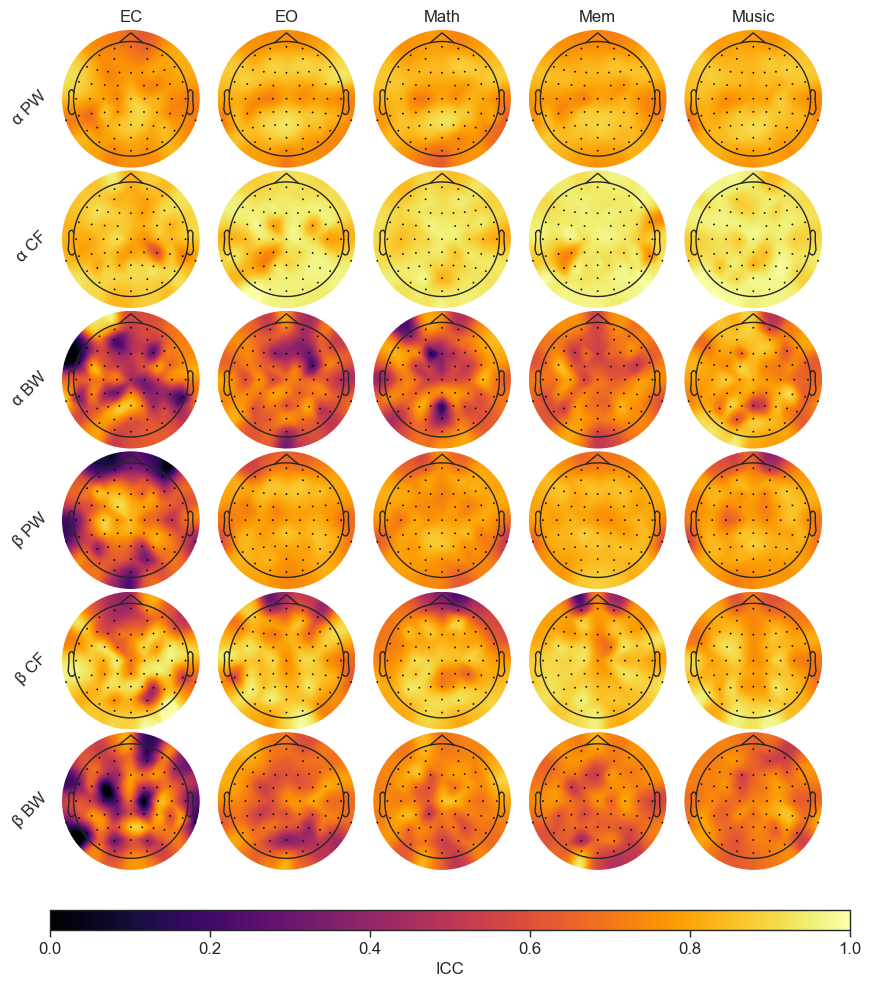

In [17]:
#Plot the ICCs for paramaterized activity
plt.figure(1, constrained_layout=True)
fig, axs = plt.subplots(6, 5)

im, cm = plot_topomap(icc_chan_eo_alpha_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 0])
im, cm = plot_topomap(icc_chan_ec_alpha_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 1])
im, cm = plot_topomap(icc_chan_math_alpha_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 2])
im, cm = plot_topomap(icc_chan_mem_alpha_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 3])
im, cm = plot_topomap(icc_chan_music_alpha_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[0, 4])

im, cm = plot_topomap(icc_chan_eo_alpha_param_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 0])
im, cm = plot_topomap(icc_chan_ec_alpha_param_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 1])
im, cm = plot_topomap(icc_chan_math_alpha_param_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 2])
im, cm = plot_topomap(icc_chan_mem_alpha_param_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 3])
im, cm = plot_topomap(icc_chan_music_alpha_param_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[1, 4])

im, cm = plot_topomap(icc_chan_eo_alpha_param_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 0])
im, cm = plot_topomap(icc_chan_ec_alpha_param_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 1])
im, cm = plot_topomap(icc_chan_math_alpha_param_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 2])
im, cm = plot_topomap(icc_chan_mem_alpha_param_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 3])
im, cm = plot_topomap(icc_chan_music_alpha_param_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[2, 4])

im, cm = plot_topomap(icc_chan_eo_beta_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[3, 0])
im, cm = plot_topomap(icc_chan_ec_beta_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[3, 1])
im, cm = plot_topomap(icc_chan_math_beta_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[3, 2])
im, cm = plot_topomap(icc_chan_mem_beta_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[3, 3])
im, cm = plot_topomap(icc_chan_music_beta_param, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[3, 4])

im, cm = plot_topomap(icc_chan_eo_beta_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[4, 0])
im, cm = plot_topomap(icc_chan_ec_beta_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[4, 1])
im, cm = plot_topomap(icc_chan_math_beta_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[4, 2])
im, cm = plot_topomap(icc_chan_mem_beta_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[4, 3])
im, cm = plot_topomap(icc_chan_music_beta_freq, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[4, 4])

im, cm = plot_topomap(icc_chan_eo_beta_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[5, 0])
im, cm = plot_topomap(icc_chan_ec_beta_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[5, 1])
im, cm = plot_topomap(icc_chan_math_beta_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[5, 2])
im, cm = plot_topomap(icc_chan_mem_beta_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[5, 3])
im, cm = plot_topomap(icc_chan_music_beta_bw, chan_info.info, size=5, cmap='jet',
                      show=False, contours=0, image_interp='cubic', vlim=(0, 1), axes=axs[5, 4])


# Plot colorbar
ax_x_start = 0.12
ax_y_start = 0.05
ax_width = 0.8
ax_height = 0.02


cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_width, ax_height])
clb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
clb.set_label('ICC', fontsize=12)
clb.ax.tick_params(labelsize=12)

# Plot titles
axs[0, 0].set_title('EC', fontsize=12)
axs[0, 1].set_title('EO', fontsize=12)
axs[0, 2].set_title('Math', fontsize=12)
axs[0, 3].set_title('Mem', fontsize=12)
axs[0, 4].set_title('Music', fontsize=12)

# Set axis labels, titles, and ticks, use a 45 degree rotation for the y-axis labels
axs[0, 0].set_ylabel('\u03B1 PW', fontsize=12, rotation=45, ha='right')
axs[1, 0].set_ylabel('\u03B1 CF', fontsize=12, rotation=45, ha='right')
axs[2, 0].set_ylabel('\u03B1 BW', fontsize=12, rotation=45, ha='right')
axs[3, 0].set_ylabel('\u03B2 PW', fontsize=12, rotation=45, ha='right')
axs[4, 0].set_ylabel('\u03B2 CF', fontsize=12, rotation=45, ha='right')
axs[5, 0].set_ylabel('\u03B2 BW', fontsize=12, rotation=45, ha='right')

# Set cmap and colorbar to be the same for all plots (this is a bit of a hack)
for i in range(0, 5):
    axs[0, i].images[0].set_cmap(mapping)
    axs[1, i].images[0].set_cmap(mapping)
    axs[2, i].images[0].set_cmap(mapping)
    axs[3, i].images[0].set_cmap(mapping)
    axs[4, i].images[0].set_cmap(mapping)
    axs[5, i].images[0].set_cmap(mapping)


# Set plot dimensions and spacing
fig.set_size_inches(10, 10)
fig.subplots_adjust(wspace=0.02, hspace=0.02)


#Save figure to home directory
fig.savefig('ICC_periodic_chan.png', dpi=300)

<Figure size 640x480 with 0 Axes>

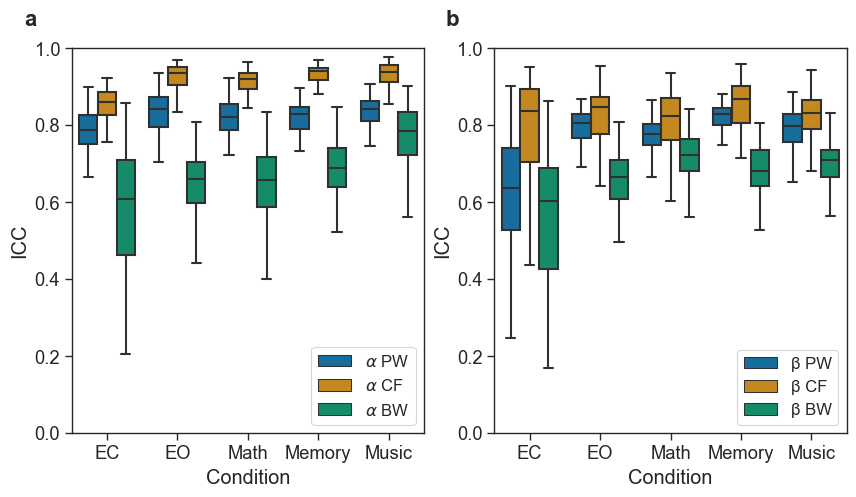

In [18]:
#Box plots for paramaterized activity

# Plot icc_plotdat_params_alpha and icc_plotdat_params_beta together as subplots
plt.figure(6, constrained_layout=True)
fig, ax = plt.subplots(1, 2)
# Set size
fig.set_size_inches(10, 5)


# Paramaterised alpha power
ECs_alpha_mean = pd.DataFrame([np.array(icc_chan_eo_alpha_param), np.repeat(
    "EO", 61), np.repeat("Alpha Mean", 61)]).T
EOs_alpha_mean = pd.DataFrame([np.array(icc_chan_ec_alpha_param), np.repeat(
    "EC", 61), np.repeat("Alpha Mean", 61)]).T
maths_alpha_mean = pd.DataFrame([np.array(icc_chan_math_alpha_param), np.repeat(
    "Math", 61), np.repeat("Alpha Mean", 61)]).T
mems_alpha_mean = pd.DataFrame([np.array(icc_chan_mem_alpha_param), np.repeat(
    "Memory", 61), np.repeat("Alpha Mean", 61)]).T
musics_alpha_mean = pd.DataFrame([np.array(icc_chan_music_alpha_param), np.repeat(
    "Music", 61), np.repeat("Alpha Mean", 61)]).T

# Paramaterised alpha frequency
ECs_alpha_freq = pd.DataFrame([np.array(icc_chan_eo_alpha_param_freq), np.repeat(
    "EO", 61), np.repeat("Alpha Frequency", 61)]).T
EOs_alpha_freq = pd.DataFrame([np.array(icc_chan_ec_alpha_param_freq), np.repeat(
    "EC", 61), np.repeat("Alpha Frequency", 61)]).T
maths_alpha_freq = pd.DataFrame([np.array(icc_chan_math_alpha_param_freq), np.repeat(
    "Math", 61), np.repeat("Alpha Frequency", 61)]).T
mems_alpha_freq = pd.DataFrame([np.array(icc_chan_mem_alpha_param_freq), np.repeat(
    "Memory", 61), np.repeat("Alpha Frequency", 61)]).T
musics_alpha_freq = pd.DataFrame([np.array(icc_chan_music_alpha_param_freq), np.repeat(
    "Music", 61), np.repeat("Alpha Frequency", 61)]).T

# Alpha bandwidth
ECs_alpha_bandwidth = pd.DataFrame([np.array(icc_chan_eo_alpha_param_bw), np.repeat(
    "EO", 61), np.repeat("Alpha Bandwidth", 61)]).T
EOs_alpha_bandwidth = pd.DataFrame([np.array(icc_chan_ec_alpha_param_bw), np.repeat(
    "EC", 61), np.repeat("Alpha Bandwidth", 61)]).T
maths_alpha_bandwidth = pd.DataFrame([np.array(icc_chan_math_alpha_param_bw), np.repeat(
    "Math", 61), np.repeat("Alpha Bandwidth", 61)]).T
mems_alpha_bandwidth = pd.DataFrame([np.array(icc_chan_mem_alpha_param_bw), np.repeat(
    "Memory", 61), np.repeat("Alpha Bandwidth", 61)]).T
musics_alpha_bandwidth = pd.DataFrame([np.array(icc_chan_music_alpha_param_bw), np.repeat(
    "Music", 61), np.repeat("Alpha Bandwidth", 61)]).T

# Paramaterised beta power
ECs_beta_mean = pd.DataFrame([np.array(icc_chan_eo_beta_param), np.repeat(
    "EO", 61), np.repeat("Beta Mean", 61)]).T
EOs_beta_mean = pd.DataFrame([np.array(icc_chan_ec_beta_param), np.repeat(
    "EC", 61), np.repeat("Beta Mean", 61)]).T
maths_beta_mean = pd.DataFrame([np.array(icc_chan_math_beta_param), np.repeat(
    "Math", 61), np.repeat("Beta Mean", 61)]).T
mems_beta_mean = pd.DataFrame([np.array(icc_chan_mem_beta_param), np.repeat(
    "Memory", 61), np.repeat("Beta Mean", 61)]).T
musics_beta_mean = pd.DataFrame([np.array(icc_chan_music_beta_param), np.repeat(
    "Music", 61), np.repeat("Beta Mean", 61)]).T

# Paramaterised beta frequency
ECs_beta_freq = pd.DataFrame([np.array(icc_chan_eo_beta_freq), np.repeat(
    "EO", 61), np.repeat("Beta Frequency", 61)]).T
EOs_beta_freq = pd.DataFrame([np.array(icc_chan_ec_beta_freq), np.repeat(
    "EC", 61), np.repeat("Beta Frequency", 61)]).T
maths_beta_freq = pd.DataFrame([np.array(icc_chan_math_beta_freq), np.repeat(
    "Math", 61), np.repeat("Beta Frequency", 61)]).T
mems_beta_freq = pd.DataFrame([np.array(icc_chan_mem_beta_freq), np.repeat(
    "Memory", 61), np.repeat("Beta Frequency", 61)]).T
musics_beta_freq = pd.DataFrame([np.array(icc_chan_music_beta_freq), np.repeat(
    "Music", 61), np.repeat("Beta Frequency", 61)]).T

# Beta bandwidth
ECs_beta_bandwidth = pd.DataFrame([np.array(icc_chan_eo_beta_bw), np.repeat(
    "EO", 61), np.repeat("Beta Bandwidth", 61)]).T
EOs_beta_bandwidth = pd.DataFrame([np.array(icc_chan_ec_beta_bw), np.repeat(
    "EC", 61), np.repeat("Beta Bandwidth", 61)]).T
maths_beta_bandwidth = pd.DataFrame([np.array(icc_chan_math_beta_bw), np.repeat(
    "Math", 61), np.repeat("Beta Bandwidth", 61)]).T
mems_beta_bandwidth = pd.DataFrame([np.array(icc_chan_mem_beta_bw), np.repeat(
    "Memory", 61), np.repeat("Beta Bandwidth", 61)]).T
musics_beta_bandwidth = pd.DataFrame([np.array(icc_chan_music_beta_bw), np.repeat(
    "Music", 61), np.repeat("Beta Bandwidth", 61)]).T

# Merge the dataframes
icc_plotdat_params_alpha = pd.concat([ECs_alpha_mean, EOs_alpha_mean, maths_alpha_mean, mems_alpha_mean, musics_alpha_mean, ECs_alpha_freq, EOs_alpha_freq, maths_alpha_freq,
                                     mems_alpha_freq, musics_alpha_freq, ECs_alpha_bandwidth, EOs_alpha_bandwidth, maths_alpha_bandwidth, mems_alpha_bandwidth, musics_alpha_bandwidth], axis=0)

icc_plotdat_params_alpha.columns = ['ICC', 'Condition', 'EEG Measure']
icc_plotdat_params_alpha = icc_plotdat_params_alpha.astype(
    {'ICC': 'float64'}, copy=False)


icc_plotdat_params_beta = pd.concat([ECs_beta_mean, EOs_beta_mean, maths_beta_mean, mems_beta_mean, musics_beta_mean, ECs_beta_freq, EOs_beta_freq, maths_beta_freq,
                                    mems_beta_freq, musics_beta_freq, ECs_beta_bandwidth, EOs_beta_bandwidth, maths_beta_bandwidth, mems_beta_bandwidth, musics_beta_bandwidth], ignore_index=True)

icc_plotdat_params_beta.columns = ['ICC', 'Condition', 'EEG Measure']
icc_plotdat_params_beta = icc_plotdat_params_beta.astype(
    {'ICC': 'float64'}, copy=False)


sns.boxplot(x="Condition", y="ICC", hue="EEG Measure", data=icc_plotdat_params_alpha,
            palette="colorblind", dodge=True, ax=ax[0], showfliers=False)
ax[0].set_xticklabels(['EC', 'EO', 'Math', "Memory", "Music"])
sns.boxplot(x="Condition", y="ICC", hue="EEG Measure", data=icc_plotdat_params_beta,
            palette="colorblind", dodge=True, ax=ax[1], showfliers=False)
ax[1].set_xticklabels(['EC', 'EO', 'Math', "Memory", "Music"])

# Set the width to be an a4 page
fig.set_size_inches(10, 5)

# Remove the legend title
ax[0].get_legend().set_title(None)
ax[1].get_legend().set_title(None)

# Set legend font size
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

# Change the alpha and beta text in the ledgends to be the greek characters in unicode
ax[0].legend_.texts[0].set_text(u'$\\alpha$ PW')
ax[0].legend_.texts[1].set_text(u'$\\alpha$ CF')
ax[0].legend_.texts[2].set_text(u'$\\alpha$ BW')
ax[1].legend_.texts[0].set_text(u'\u03B2 PW')
ax[1].legend_.texts[1].set_text(u'\u03B2 CF')
ax[1].legend_.texts[2].set_text(u'\u03B2 BW')

# Set y axis to be between 0 and 1
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)

# Put a and b on the plots
ax[0].text(-0.1, 1.1, 'a', transform=ax[0].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='right')
ax[1].text(-0.1, 1.1, 'b', transform=ax[1].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='right')

#Save the figure
fig.savefig('ICC_periopdic_icc_boxplot.png', dpi=300, bbox_inches='tight')

In [19]:
# Export average iccs for each condition and eeg measure and put them into a dataframe. Average across sensors first

# Exponent
icc_ec_exponent = np.mean(icc_chan_ec_exponent)
icc_eo_exponent = np.mean(icc_chan_eo_exponent)
icc_math_exponent = np.mean(icc_chan_math_exponent)
icc_mem_exponent = np.mean(icc_chan_mem_exponent)
icc_music_exponent = np.mean(icc_chan_music_exponent)

# Offset
icc_ec_offset = np.mean(icc_chan_ec_offset)
icc_eo_offset = np.mean(icc_chan_eo_offset)
icc_math_offset = np.mean(icc_chan_math_offset)
icc_mem_offset = np.mean(icc_chan_mem_offset)
icc_music_offset = np.mean(icc_chan_music_offset)

# Total alpha
icc_ec_total_alpha = np.mean(icc_chan_ec_alpha_mean)
icc_eo_total_alpha = np.mean(icc_chan_eo_alpha_mean)
icc_math_total_alpha = np.mean(icc_chan_math_alpha_mean)
icc_mem_total_alpha = np.mean(icc_chan_mem_alpha_mean)
icc_music_total_alpha = np.mean(icc_chan_music_alpha_mean)

# Total beta
icc_ec_total_beta = np.mean(icc_chan_ec_beta_mean)
icc_eo_total_beta = np.mean(icc_chan_eo_beta_mean)
icc_math_total_beta = np.mean(icc_chan_math_beta_mean)
icc_mem_total_beta = np.mean(icc_chan_mem_beta_mean)
icc_music_total_beta = np.mean(icc_chan_music_beta_mean)

# Paramaterised alpha
icc_ec_param_alpha = np.mean(icc_chan_ec_alpha_param)
icc_eo_param_alpha = np.mean(icc_chan_eo_alpha_param)
icc_math_param_alpha = np.mean(icc_chan_math_alpha_param)
icc_mem_param_alpha = np.mean(icc_chan_mem_alpha_param)
icc_music_param_alpha = np.mean(icc_chan_music_alpha_param)

# Paramaterised alpha frequency
icc_ec_param_alpha_freq = np.mean(icc_chan_ec_alpha_param_freq)
icc_eo_param_alpha_freq = np.mean(icc_chan_eo_alpha_param_freq)
icc_math_param_alpha_freq = np.mean(icc_chan_math_alpha_param_freq)
icc_mem_param_alpha_freq = np.mean(icc_chan_mem_alpha_param_freq)
icc_music_param_alpha_freq = np.mean(icc_chan_music_alpha_param_freq)

# Paramaterised alpha bandwidth
icc_ec_param_alpha_bw = np.mean(icc_chan_ec_alpha_param_bw)
icc_eo_param_alpha_bw = np.mean(icc_chan_eo_alpha_param_bw)
icc_math_param_alpha_bw = np.mean(icc_chan_math_alpha_param_bw)
icc_mem_param_alpha_bw = np.mean(icc_chan_mem_alpha_param_bw)
icc_music_param_alpha_bw = np.mean(icc_chan_music_alpha_param_bw)

# Paramaterised beta
icc_ec_param_beta = np.mean(icc_chan_ec_beta_param)
icc_eo_param_beta = np.mean(icc_chan_eo_beta_param)
icc_math_param_beta = np.mean(icc_chan_math_beta_param)
icc_mem_param_beta = np.mean(icc_chan_mem_beta_param)
icc_music_param_beta = np.mean(icc_chan_music_beta_param)

# Paramaterised beta frequency
icc_ec_param_beta_freq = np.mean(icc_chan_ec_beta_freq)
icc_eo_param_beta_freq = np.mean(icc_chan_eo_beta_freq)
icc_math_param_beta_freq = np.mean(icc_chan_math_beta_freq)
icc_mem_param_beta_freq = np.mean(icc_chan_mem_beta_freq)
icc_music_param_beta_freq = np.mean(icc_chan_music_beta_freq)

# Paramaterised beta bandwidth
icc_ec_param_beta_bw = np.mean(icc_chan_ec_beta_bw)
icc_eo_param_beta_bw = np.mean(icc_chan_eo_beta_bw)
icc_math_param_beta_bw = np.mean(icc_chan_math_beta_bw)
icc_mem_param_beta_bw = np.mean(icc_chan_mem_beta_bw)
icc_music_param_beta_bw = np.mean(icc_chan_music_beta_bw)

# Put all the ICCs into a dataframe that is 10 rows by 5 columns

icc_dat = {'EC': [icc_ec_exponent, icc_ec_offset, icc_ec_total_alpha, icc_ec_total_beta, icc_ec_param_alpha, icc_ec_param_alpha_freq, icc_ec_param_alpha_bw, icc_ec_param_beta, icc_ec_param_beta_freq, icc_ec_param_beta_bw],
           'EO': [icc_eo_exponent, icc_eo_offset, icc_eo_total_alpha, icc_eo_total_beta, icc_eo_param_alpha, icc_eo_param_alpha_freq, icc_eo_param_alpha_bw, icc_eo_param_beta, icc_eo_param_beta_freq, icc_eo_param_beta_bw],
           'Math': [icc_math_exponent, icc_math_offset, icc_math_total_alpha, icc_math_total_beta, icc_math_param_alpha, icc_math_param_alpha_freq, icc_math_param_alpha_bw, icc_math_param_beta, icc_math_param_beta_freq, icc_math_param_beta_bw],
           'Mem': [icc_mem_exponent, icc_mem_offset, icc_mem_total_alpha, icc_mem_total_beta, icc_mem_param_alpha, icc_mem_param_alpha_freq, icc_mem_param_alpha_bw, icc_mem_param_beta, icc_mem_param_beta_freq, icc_mem_param_beta_bw],
           'Music': [icc_music_exponent, icc_music_offset, icc_music_total_alpha, icc_music_total_beta, icc_music_param_alpha, icc_music_param_alpha_freq, icc_music_param_alpha_bw, icc_music_param_beta, icc_music_param_beta_freq, icc_music_param_beta_bw]}


icc_dat = pd.DataFrame(icc_dat)
# Add in the names of the rows
icc_dat.index = ['Exponent', 'Offset', 'Total Alpha', 'Total Beta', 'Param Alpha',
                 'Param Alpha Freq', 'Param Alpha BW', 'Param Beta', 'Param Beta Freq', 'Param Beta BW']

# save the dataframe to a csv file
icc_dat.to_csv('ICC_dat.csv')

#Make a table of the ICCs, rounding to 2 decimal places, highlighting values above .74 in green
icc_dat.style.format("{:.2f}")



,EC,EO,Math,Mem,Music
Exponent,0.73,0.70,0.71,0.64,0.70
Offset,0.85,0.81,0.85,0.81,0.84
Total Alpha,0.89,0.84,0.88,0.89,0.88
Total Beta,0.83,0.77,0.82,0.84,0.83
Param Alpha,0.83,0.79,0.81,0.82,0.83
Param Alpha Freq,0.91,0.85,0.91,0.92,0.93
Param Alpha BW,0.63,0.58,0.63,0.68,0.77
Param Beta,0.79,0.62,0.77,0.81,0.78
Param Beta Freq,0.81,0.79,0.80,0.85,0.82
Param Beta BW,0.65,0.55,0.72,0.67,0.70


In [20]:
# Export average p-values for each condition and eeg measure and put them into a dataframe
# Exponent
p_ec_exponent = pd.DataFrame(
    [np.array(icc_p_ec_exponent), np.repeat("EC", 61), np.repeat("Exponent", 61)]).T
p_eo_exponent = pd.DataFrame(
    [np.array(icc_p_eo_exponent), np.repeat("EO", 61), np.repeat("Exponent", 61)]).T
p_math_exponent = pd.DataFrame([np.array(icc_p_math_exponent), np.repeat(
    "Math", 61), np.repeat("Exponent", 61)]).T
p_mem_exponent = pd.DataFrame([np.array(icc_p_mem_exponent), np.repeat(
    "Memory", 61), np.repeat("Exponent", 61)]).T
p_music_exponent = pd.DataFrame([np.array(icc_p_music_exponent), np.repeat(
    "Music", 61), np.repeat("Exponent", 61)]).T

# Offset
p_ec_offset = pd.DataFrame(
    [np.array(icc_p_ec_offset), np.repeat("EC", 61), np.repeat("Offset", 61)]).T
p_eo_offset = pd.DataFrame(
    [np.array(icc_p_eo_offset), np.repeat("EO", 61), np.repeat("Offset", 61)]).T
p_math_offset = pd.DataFrame(
    [np.array(icc_p_math_offset), np.repeat("Math", 61), np.repeat("Offset", 61)]).T
p_mem_offset = pd.DataFrame([np.array(icc_p_mem_offset), np.repeat(
    "Memory", 61), np.repeat("Offset", 61)]).T
p_music_offset = pd.DataFrame([np.array(icc_p_music_offset), np.repeat(
    "Music", 61), np.repeat("Offset", 61)]).T

# Total alpha
p_ec_total_alpha = pd.DataFrame([np.array(icc_p_ec_alpha_mean), np.repeat(
    "EC", 61), np.repeat("Total Alpha", 61)]).T
p_eo_total_alpha = pd.DataFrame([np.array(icc_p_eo_alpha_mean), np.repeat(
    "EO", 61), np.repeat("Total Alpha", 61)]).T
p_math_total_alpha = pd.DataFrame([np.array(icc_p_math_alpha_mean), np.repeat(
    "Math", 61), np.repeat("Total Alpha", 61)]).T
p_mem_total_alpha = pd.DataFrame([np.array(icc_p_mem_alpha_mean), np.repeat(
    "Memory", 61), np.repeat("Total Alpha", 61)]).T
p_music_total_alpha = pd.DataFrame([np.array(icc_p_music_alpha_mean), np.repeat(
    "Music", 61), np.repeat("Total Alpha", 61)]).T

# Total beta
p_ec_total_beta = pd.DataFrame([np.array(icc_p_ec_beta_mean), np.repeat(
    "EC", 61), np.repeat("Total Beta", 61)]).T
p_eo_total_beta = pd.DataFrame([np.array(icc_p_eo_beta_mean), np.repeat(
    "EO", 61), np.repeat("Total Beta", 61)]).T
p_math_total_beta = pd.DataFrame([np.array(icc_p_math_beta_mean), np.repeat(
    "Math", 61), np.repeat("Total Beta", 61)]).T
p_mem_total_beta = pd.DataFrame([np.array(icc_p_mem_beta_mean), np.repeat(
    "Memory", 61), np.repeat("Total Beta", 61)]).T
p_music_total_beta = pd.DataFrame([np.array(icc_p_music_beta_mean), np.repeat(
    "Music", 61), np.repeat("Total Beta", 61)]).T

# Total theta
p_ec_total_theta = pd.DataFrame([np.array(icc_p_ec_theta_mean), np.repeat(
    "EC", 61), np.repeat("Total Theta", 61)]).T
p_eo_total_theta = pd.DataFrame([np.array(icc_p_eo_theta_mean), np.repeat(
    "EO", 61), np.repeat("Total Theta", 61)]).T
p_math_total_theta = pd.DataFrame([np.array(icc_p_math_theta_mean), np.repeat(
    "Math", 61), np.repeat("Total Theta", 61)]).T
p_mem_total_theta = pd.DataFrame([np.array(icc_p_mem_theta_mean), np.repeat(
    "Memory", 61), np.repeat("Total Theta", 61)]).T
p_music_total_theta = pd.DataFrame([np.array(icc_p_music_theta_mean), np.repeat(
    "Music", 61), np.repeat("Total Theta", 61)]).T

# Paramaterised alpha power
p_ec_param_alpha = pd.DataFrame([np.array(icc_p_ec_alpha_param), np.repeat(
    "EC", 61), np.repeat("Param Alpha", 61)]).T
p_eo_param_alpha = pd.DataFrame([np.array(icc_p_eo_alpha_param), np.repeat(
    "EO", 61), np.repeat("Param Alpha", 61)]).T
p_math_param_alpha = pd.DataFrame([np.array(icc_p_math_alpha_param), np.repeat(
    "Math", 61), np.repeat("Param Alpha", 61)]).T
p_mem_param_alpha = pd.DataFrame([np.array(icc_p_mem_alpha_param), np.repeat(
    "Memory", 61), np.repeat("Param Alpha", 61)]).T
p_music_param_alpha = pd.DataFrame([np.array(icc_p_music_alpha_param), np.repeat(
    "Music", 61), np.repeat("Param Alpha", 61)]).T

# Paramterised alpha frequency
p_ec_param_alpha_freq = pd.DataFrame([np.array(icc_p_ec_alpha_param_freq), np.repeat(
    "EC", 61), np.repeat("Param Alpha Freq", 61)]).T
p_eo_param_alpha_freq = pd.DataFrame([np.array(icc_p_eo_alpha_param_freq), np.repeat(
    "EO", 61), np.repeat("Param Alpha Freq", 61)]).T
p_math_param_alpha_freq = pd.DataFrame([np.array(icc_p_math_alpha_param_freq), np.repeat(
    "Math", 61), np.repeat("Param Alpha Freq", 61)]).T
p_mem_param_alpha_freq = pd.DataFrame([np.array(icc_p_mem_alpha_param_freq), np.repeat(
    "Memory", 61), np.repeat("Param Alpha Freq", 61)]).T
p_music_param_alpha_freq = pd.DataFrame([np.array(icc_p_music_alpha_param_freq), np.repeat(
    "Music", 61), np.repeat("Param Alpha Freq", 61)]).T

# Paramaterised alpha bandwidth
p_ec_param_alpha_bw = pd.DataFrame([np.array(icc_p_ec_alpha_param_bw), np.repeat(
    "EC", 61), np.repeat("Param Alpha BW", 61)]).T
p_eo_param_alpha_bw = pd.DataFrame([np.array(icc_p_eo_alpha_param_bw), np.repeat(
    "EO", 61), np.repeat("Param Alpha BW", 61)]).T
p_math_param_alpha_bw = pd.DataFrame([np.array(icc_p_math_alpha_param_bw), np.repeat(
    "Math", 61), np.repeat("Param Alpha BW", 61)]).T
p_mem_param_alpha_bw = pd.DataFrame([np.array(icc_p_mem_alpha_param_bw), np.repeat(
    "Memory", 61), np.repeat("Param Alpha BW", 61)]).T
p_music_param_alpha_bw = pd.DataFrame([np.array(icc_p_music_alpha_param_bw), np.repeat(
    "Music", 61), np.repeat("Param Alpha BW", 61)]).T

# Paramaterised beta power
p_ec_param_beta = pd.DataFrame([np.array(icc_p_ec_beta_param), np.repeat(
    "EC", 61), np.repeat("Param Beta", 61)]).T
p_eo_param_beta = pd.DataFrame([np.array(icc_p_eo_beta_param), np.repeat(
    "EO", 61), np.repeat("Param Beta", 61)]).T
p_math_param_beta = pd.DataFrame([np.array(icc_p_math_beta_param), np.repeat(
    "Math", 61), np.repeat("Param Beta", 61)]).T
p_mem_param_beta = pd.DataFrame([np.array(icc_p_mem_beta_param), np.repeat(
    "Memory", 61), np.repeat("Param Beta", 61)]).T
p_music_param_beta = pd.DataFrame([np.array(icc_p_music_beta_param), np.repeat(
    "Music", 61), np.repeat("Param Beta", 61)]).T

# Paramterised beta frequency
p_ec_param_beta_freq = pd.DataFrame([np.array(icc_p_ec_beta_freq), np.repeat(
    "EC", 61), np.repeat("Param Beta Freq", 61)]).T
p_eo_param_beta_freq = pd.DataFrame([np.array(icc_p_eo_beta_freq), np.repeat(
    "EO", 61), np.repeat("Param Beta Freq", 61)]).T
p_math_param_beta_freq = pd.DataFrame([np.array(icc_p_math_beta_freq), np.repeat(
    "Math", 61), np.repeat("Param Beta Freq", 61)]).T
p_mem_param_beta_freq = pd.DataFrame([np.array(icc_p_mem_beta_freq), np.repeat(
    "Memory", 61), np.repeat("Param Beta Freq", 61)]).T
p_music_param_beta_freq = pd.DataFrame([np.array(icc_p_music_beta_freq), np.repeat(
    "Music", 61), np.repeat("Param Beta Freq", 61)]).T

# Paramaterised beta bandwidth
p_ec_param_beta_bw = pd.DataFrame([np.array(icc_p_ec_beta_bw), np.repeat(
    "EC", 61), np.repeat("Param Beta BW", 61)]).T
p_eo_param_beta_bw = pd.DataFrame([np.array(icc_p_eo_beta_bw), np.repeat(
    "EO", 61), np.repeat("Param Beta BW", 61)]).T
p_math_param_beta_bw = pd.DataFrame([np.array(icc_p_math_beta_bw), np.repeat(
    "Math", 61), np.repeat("Param Beta BW", 61)]).T
p_mem_param_beta_bw = pd.DataFrame([np.array(icc_p_mem_beta_bw), np.repeat(
    "Memory", 61), np.repeat("Param Beta BW", 61)]).T
p_music_param_beta_bw = pd.DataFrame([np.array(icc_p_music_beta_bw), np.repeat(
    "Music", 61), np.repeat("Param Beta BW", 61)]).T


# Merge the dataframes and calculate the average p-value for each condition and eeg measure
p_plotdat = pd.concat([p_ec_exponent, p_eo_exponent, p_math_exponent, p_mem_exponent, p_music_exponent,
                       p_ec_offset, p_eo_offset, p_math_offset, p_mem_offset, p_music_offset,
                       p_ec_total_alpha, p_eo_total_alpha, p_math_total_alpha, p_mem_total_alpha, p_music_total_alpha,
                       p_ec_total_beta, p_eo_total_beta, p_math_total_beta, p_mem_total_beta, p_music_total_beta,
                       p_ec_param_alpha, p_eo_param_alpha, p_math_param_alpha, p_mem_param_alpha, p_music_param_alpha,
                       p_ec_param_alpha_freq, p_eo_param_alpha_freq, p_math_param_alpha_freq, p_mem_param_alpha_freq, p_music_param_alpha_freq,
                       p_ec_param_alpha_bw, p_eo_param_alpha_bw, p_math_param_alpha_bw, p_mem_param_alpha_bw, p_music_param_alpha_bw,
                       p_ec_param_beta, p_eo_param_beta, p_math_param_beta, p_mem_param_beta, p_music_param_beta,
                       p_ec_param_beta_freq, p_eo_param_beta_freq, p_math_param_beta_freq, p_mem_param_beta_freq, p_music_param_beta_freq,
                       p_ec_param_beta_bw, p_eo_param_beta_bw, p_math_param_beta_bw, p_mem_param_beta_bw, p_music_param_beta_bw], axis=0)

p_plotdat.columns = ['p', 'Condition', 'EEG Measure']
p_plotdat = p_plotdat.astype({'p': 'float64'}, copy=False)
p_plotdat = p_plotdat.groupby(
    ['Condition', 'EEG Measure']).mean().reset_index()


#Organise the table to be 10 X 5
p_plotdat = p_plotdat.pivot(index='Condition', columns='EEG Measure', values='p')

#Round the values to 3 decimal places, and highlight if they are below .05
p_plotdat = p_plotdat.style.applymap(lambda x: 'background-color : green' if x < .05 else '')
p_plotdat = p_plotdat.format("{:.3f}")

p_plotdat

EEG Measure,Exponent,Offset,Param Alpha,Param Alpha BW,Param Alpha Freq,Param Beta,Param Beta BW,Param Beta Freq,Total Alpha,Total Beta
Condition,,,,,,,,,,
EC,0.000,0.000,0.000,0.005,0.000,0.000,0.001,0.000,0.000,0.000
EO,0.002,0.002,0.000,0.033,0.000,0.043,0.075,0.008,0.001,0.019
Math,0.001,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.001
Memory,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Music,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
